In [1]:
# from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf
from neurite_sandbox.tf.models import labels_to_labels
from neurite_sandbox.tf.utils.augment import add_outside_shapes
from neurite.tf.utils.augment import draw_perlin_full
from scipy.ndimage import distance_transform_edt
import scipy.ndimage as ndi
import tensorflow.keras.layers as KL
import voxelmorph as vxm


import argparse
from tensorflow.keras.callbacks import ReduceLROnPlateau
import pathlib
# import surfa as sf
import re
import json
from keras import backend as K
import param_3d
import data
import model_3d
from data_3d import *
import scipy.ndimage as ndimage

import nibabel as nib
from tqdm import tqdm
from tensorflow.keras.layers import Lambda

from utils import *
from help import *

import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Check devices
print("Available devices:", tf.config.list_physical_devices())

def get_pig_model(k1,k2):
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,2]
    input_img = Input(shape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_"+str(k1)+"_"+str(k2), 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model

def get_pig_model_128():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,2]
    input_img = Input(shape=(param_3d.img_size_128,param_3d.img_size_128,param_3d.img_size_128, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_128,param_3d.img_size_128,param_3d.img_size_128, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_6_6_128", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model

def get_pig_model_96_full():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,7]
    input_img = Input(shape=(param_3d.img_size_96,param_3d.img_size_96,param_3d.img_size_96, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_96,param_3d.img_size_96,param_3d.img_size_96, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_seg_FULL_6_6_96", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model

def get_pig_model_atlas():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,251]
    input_img = Input(shape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_seg_atlas_6_6", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model

def get_pig_model_atlas_new():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,103]
    input_img = Input(shape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_seg_atlas_6_6_new", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model
    
def get_pig_model_96():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,3]
    input_img = Input(shape=(param_3d.img_size_96,param_3d.img_size_96,param_3d.img_size_96, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_96,param_3d.img_size_96,param_3d.img_size_96, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_seg_6_6_96", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model
    
def get_pig_model_binary_96():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,2]
    input_img = Input(shape=(param_3d.img_size_96,param_3d.img_size_96,param_3d.img_size_96, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_96,param_3d.img_size_96,param_3d.img_size_96, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_6_6_96", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model

/cbica/home/dadashkj/neurite/neurite/__init__.py:33: FutureWarning: The default backend will soon be changing to 'pytorch'. If you prefer to use TensorFlow, please set the NEURITE_BACKEND environment variable to 'tensorflow'.
  backend = py.utils.get_backend()
/cbica/home/dadashkj/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


2025-05-06 16:07:34.148972: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-05-06 16:07:34.149075: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: cubic-login3
2025-05-06 16:07:34.149107: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: cubic-login3
2025-05-06 16:07:34.149295: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.73.1
2025-05-06 16:07:34.149368: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.73.1
2025-05-06 16:07:34.149385: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.73.1


In [2]:
k1=6
k2=6
# validation_folder_path = "/cubic/projects/Pig_TBI/JohnWolf/Protocols/T1_mask"
validation_folder_path = "sadia"

subfolders = [f.name for f in os.scandir(validation_folder_path) if f.is_dir()]
combined_model = get_pig_model(k1,k2)
combined_model_128 = get_pig_model_128()
combined_model_96 = get_pig_model_96()
# combined_model_96 = get_pig_model_binary_96()
# combined_model_96 = get_pig_model_atlas()
# combined_model_96 = get_pig_model_atlas_new()
atlas=False
# num_forground_classes=102 # 250
dial_param = 1 if atlas else 3

model is loading
models_gmm_6_6/weights_epoch_40.h5
model is loading
models_gmm_6_6_128/weights_epoch_760.h5
model is loading
models_gmm_seg_6_6_96/weights_epoch_720.h5


model is loading
models_gmm_6_6/weights_epoch_40.h5
model is loading
models_gmm_6_6_128/weights_epoch_760.h5
sadia/2016_6_post/image.nii.gz
[DEBUG] NiftiArrayIO.load(): no header extensions found!
(192, 192, 192)


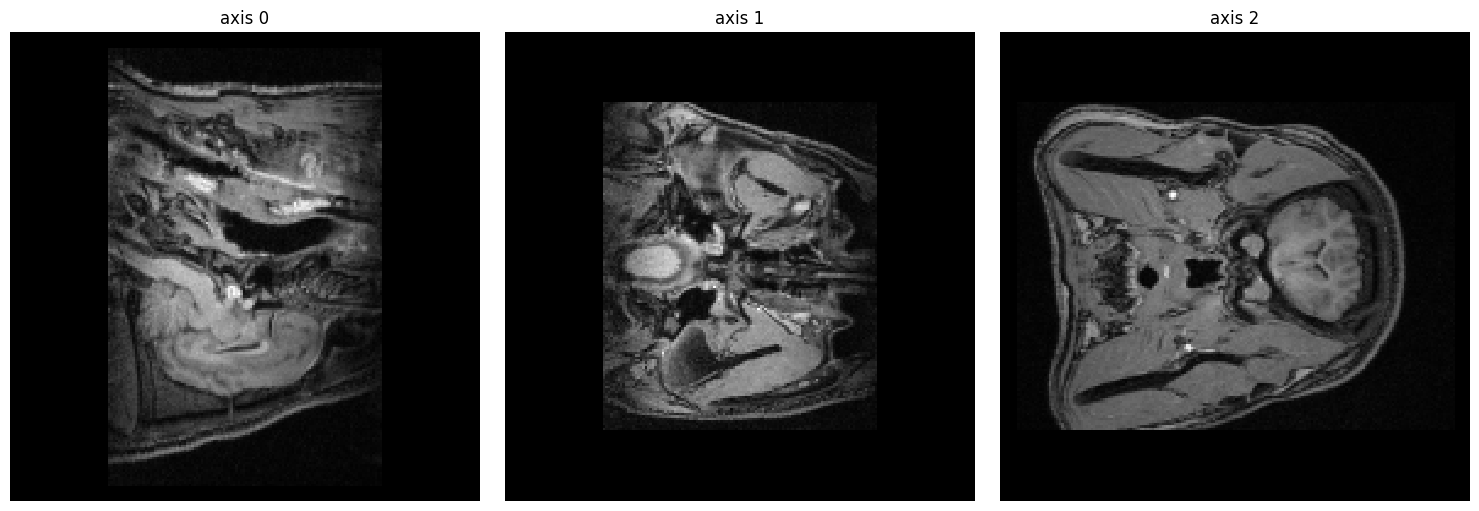

orig shape (192, 256, 160)
Initial Prediction Result:


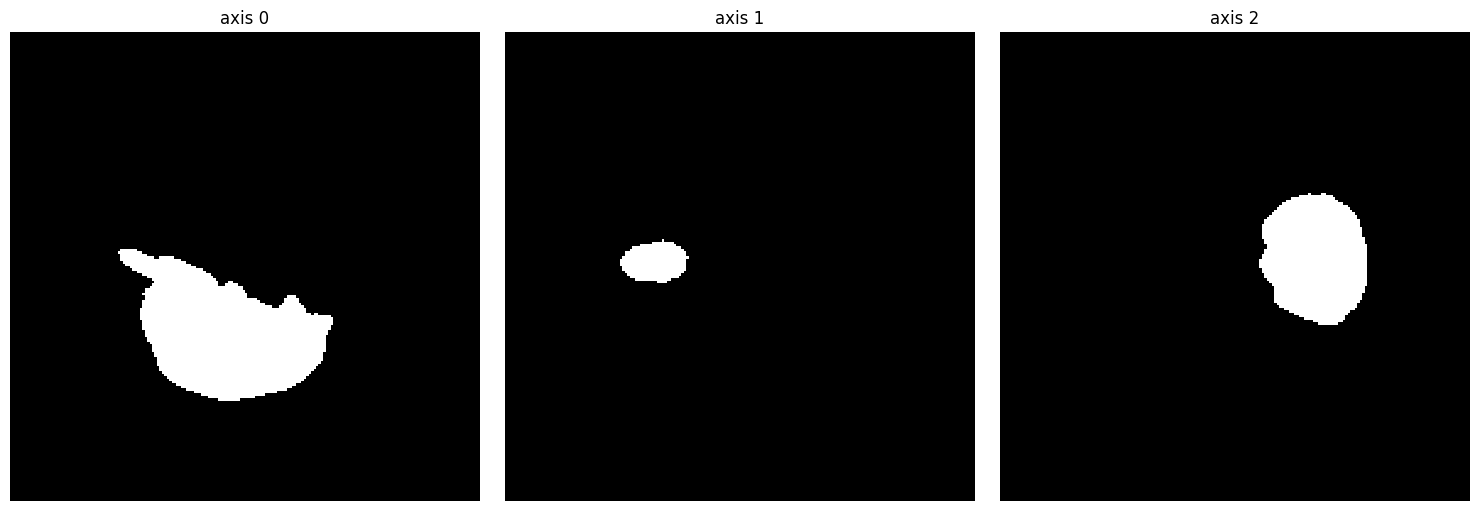

first step:  0.03079059805874836


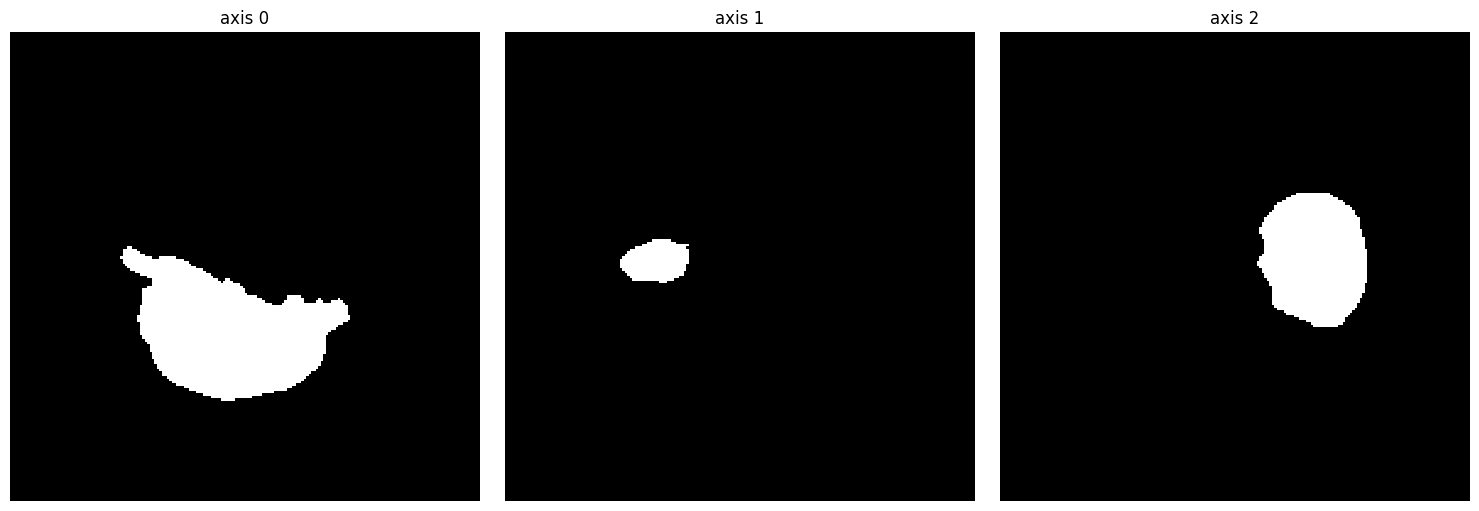

second step:  0.032894646334401804
## [0.703125   0.703125   0.70000076]
dilated image @@@@@@@@@@@@@@@@@@


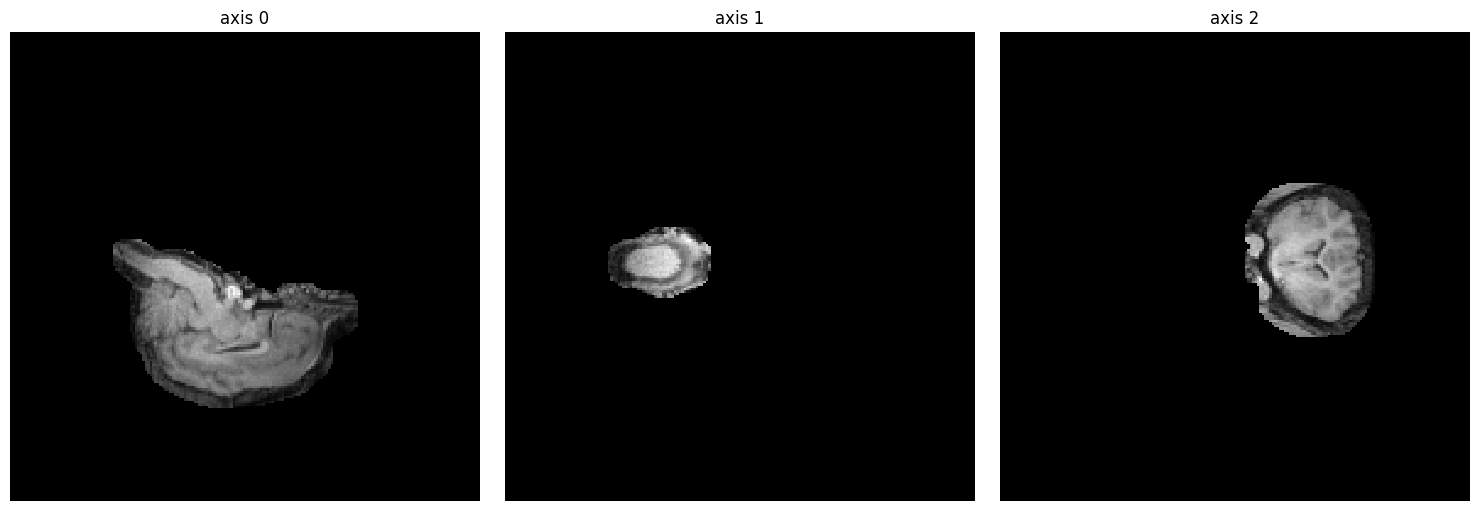

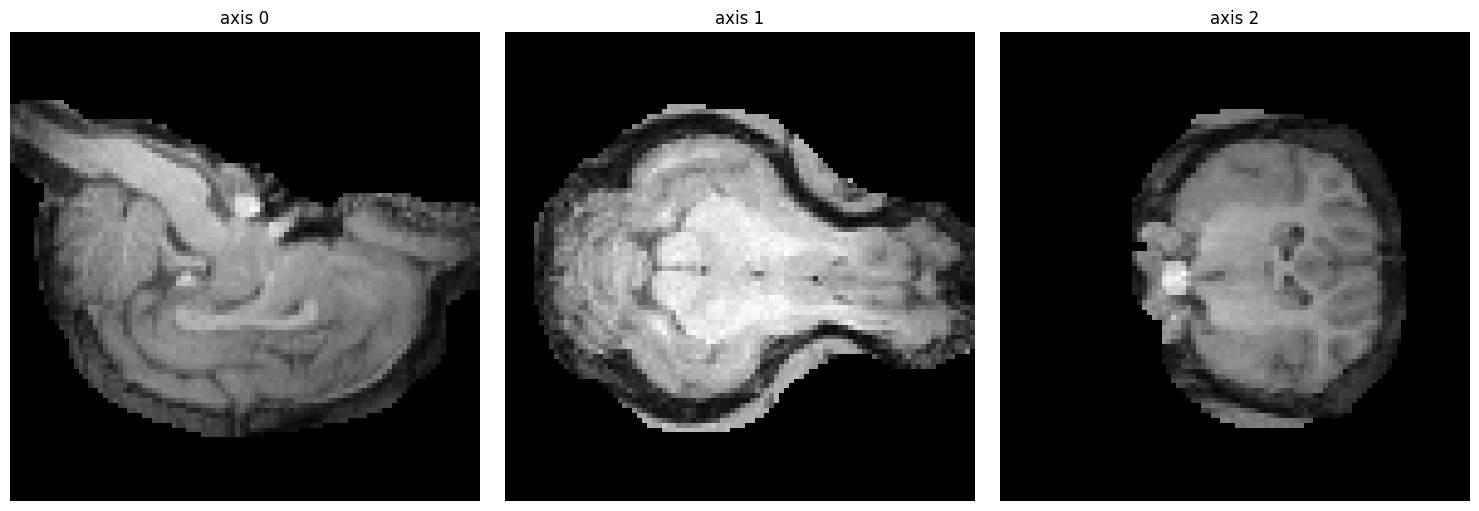

############# (96, 96, 96)
(96, 96, 96) ######


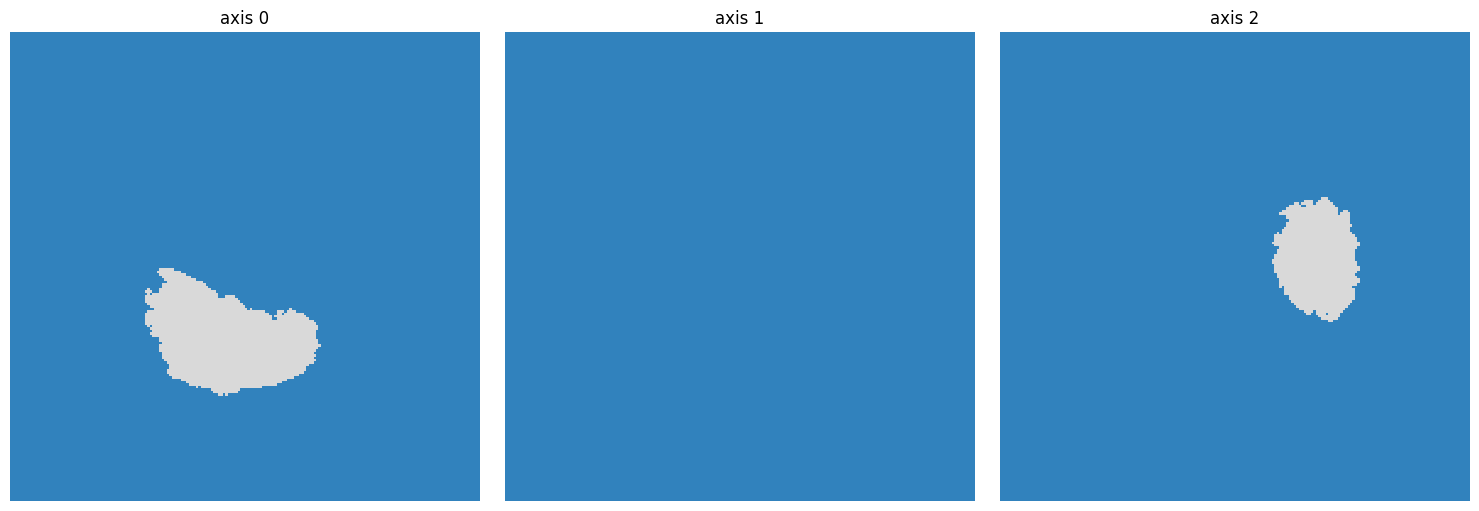

Dice coefficient for 2016_6_post: 0.0212
sadia/2016_12_post/image.nii.gz
[DEBUG] NiftiArrayIO.load(): no header extensions found!
(192, 192, 192)


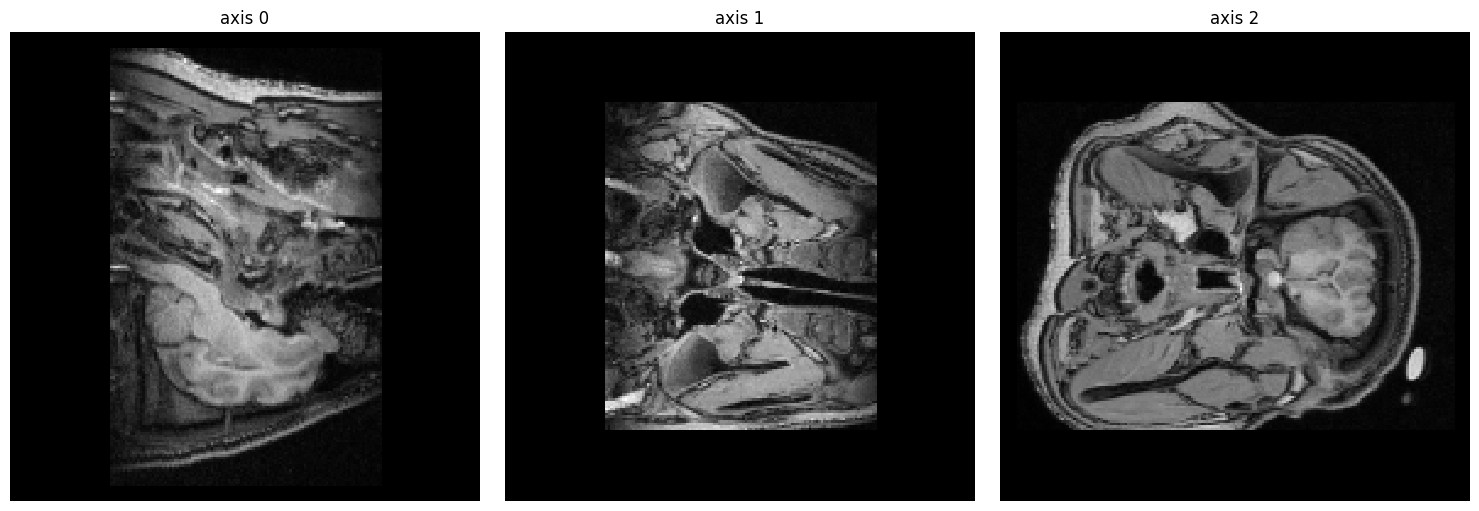

orig shape (192, 256, 160)
Initial Prediction Result:


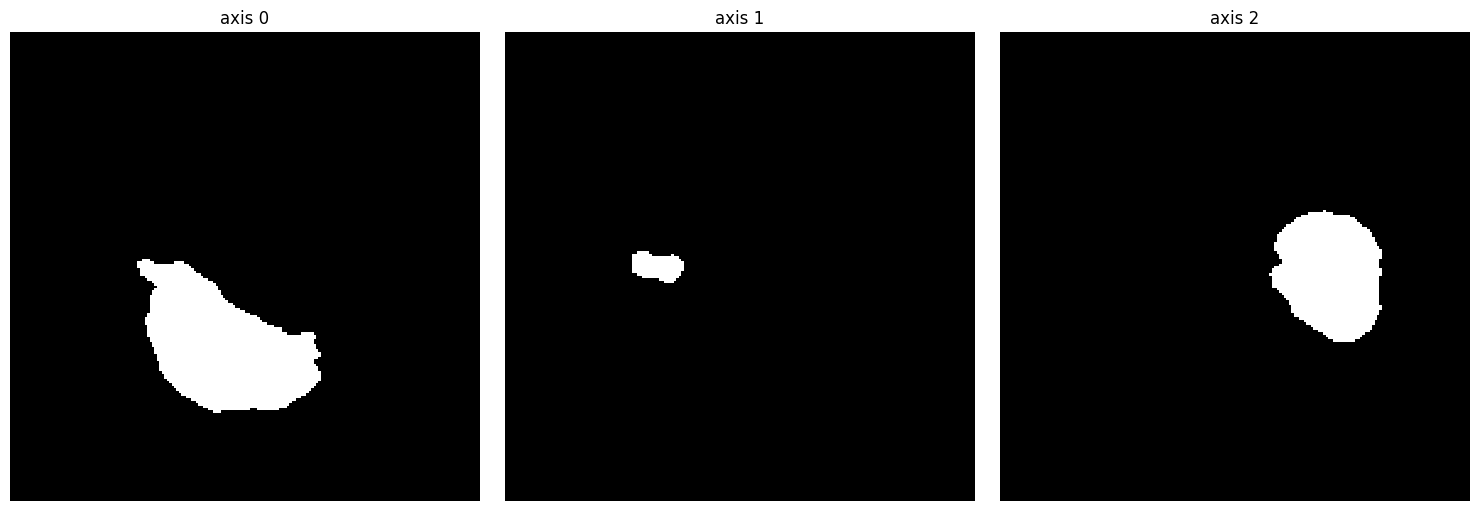

first step:  0.029936367162433038


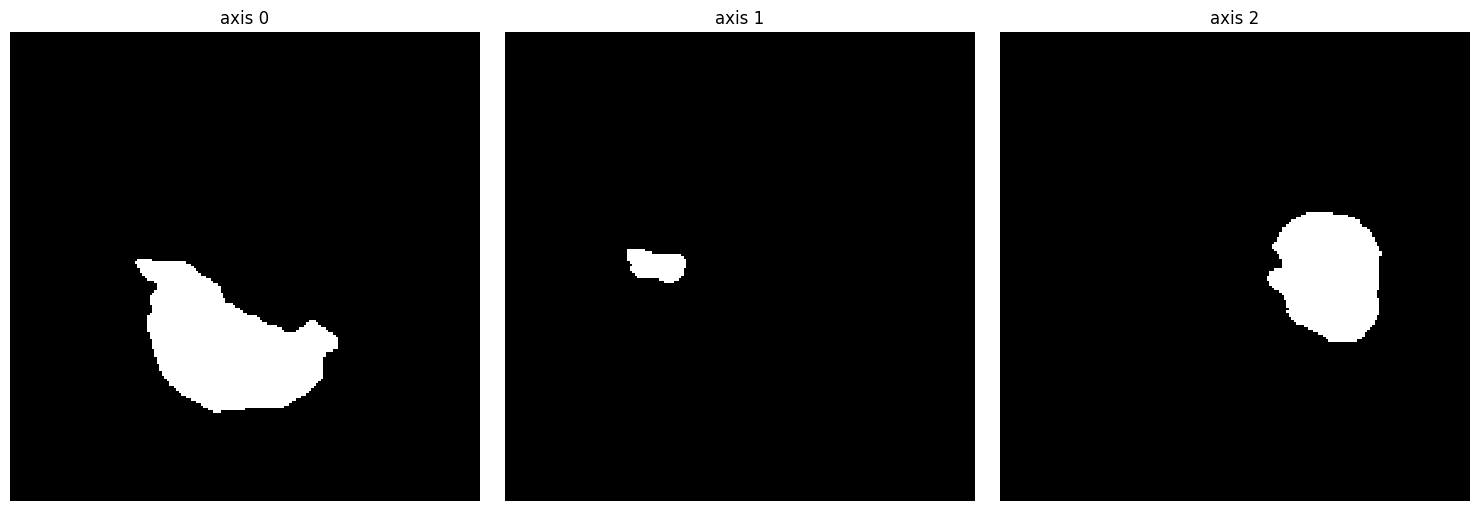

second step:  0.03160932806121853
## [0.703125   0.703125   0.69999695]
dilated image @@@@@@@@@@@@@@@@@@


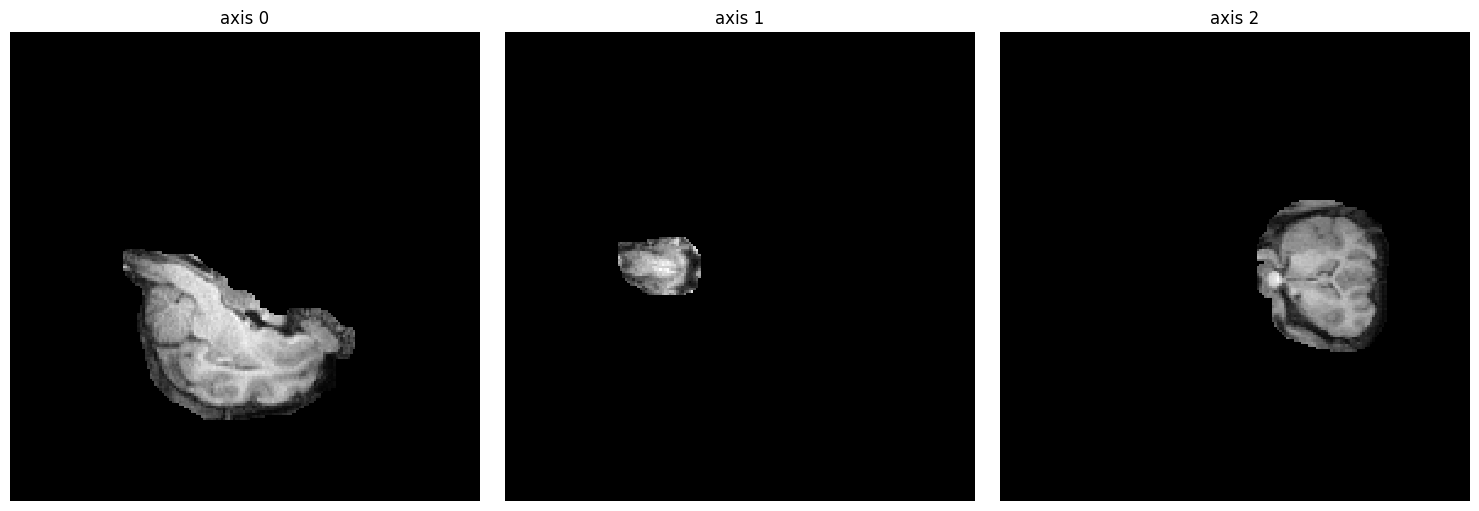

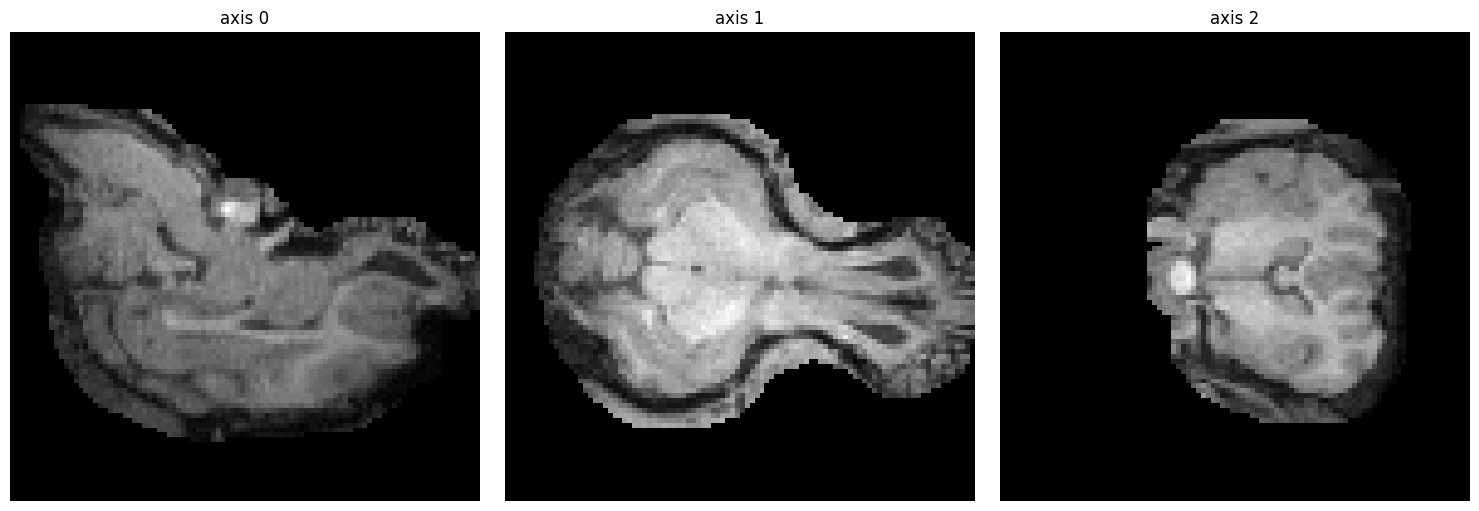

############# (96, 96, 96)
(96, 96, 96) ######


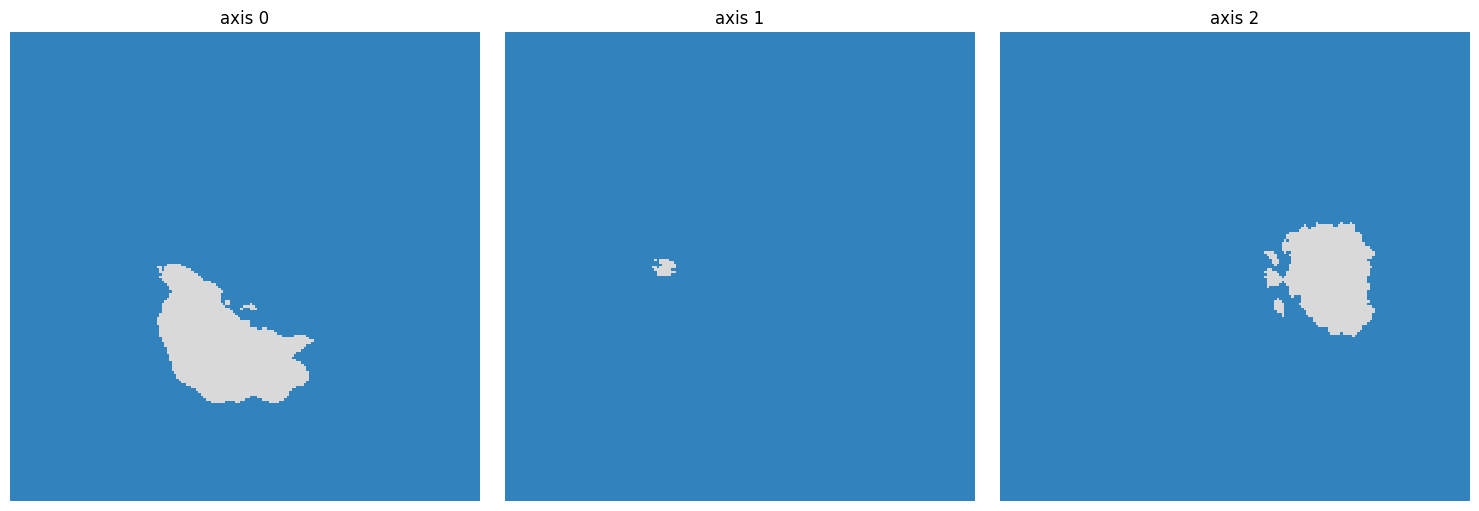

Dice coefficient for 2016_12_post: 0.0206
sadia/2017_1_post/image.nii.gz
[DEBUG] NiftiArrayIO.load(): no header extensions found!
(192, 192, 192)


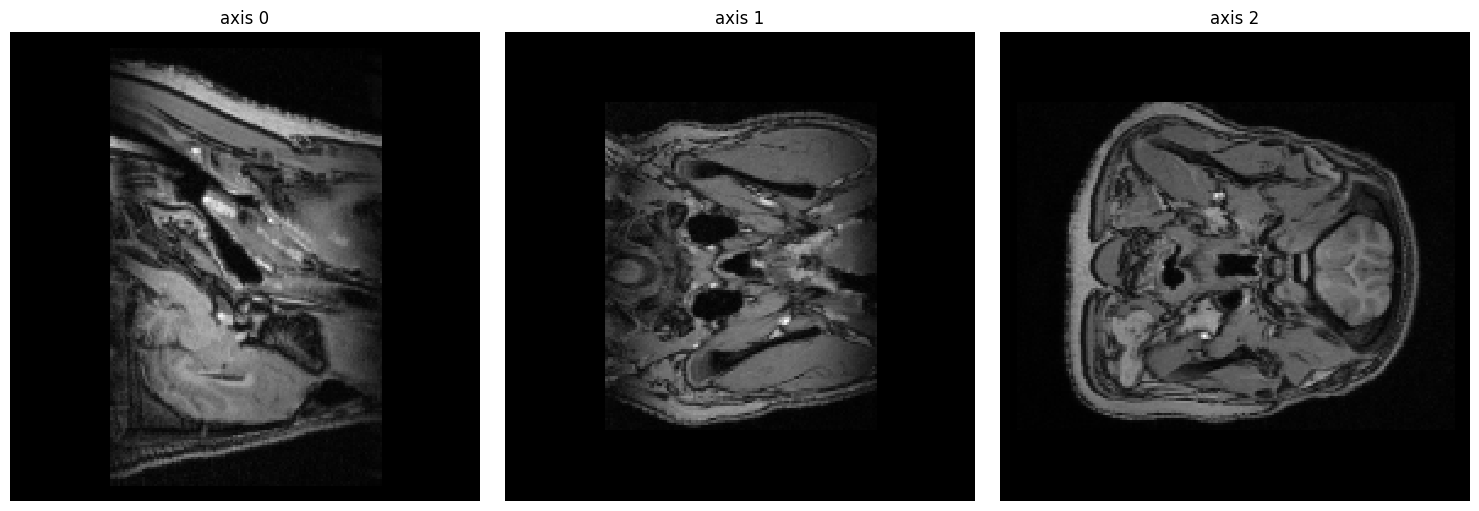

orig shape (192, 256, 160)
Initial Prediction Result:


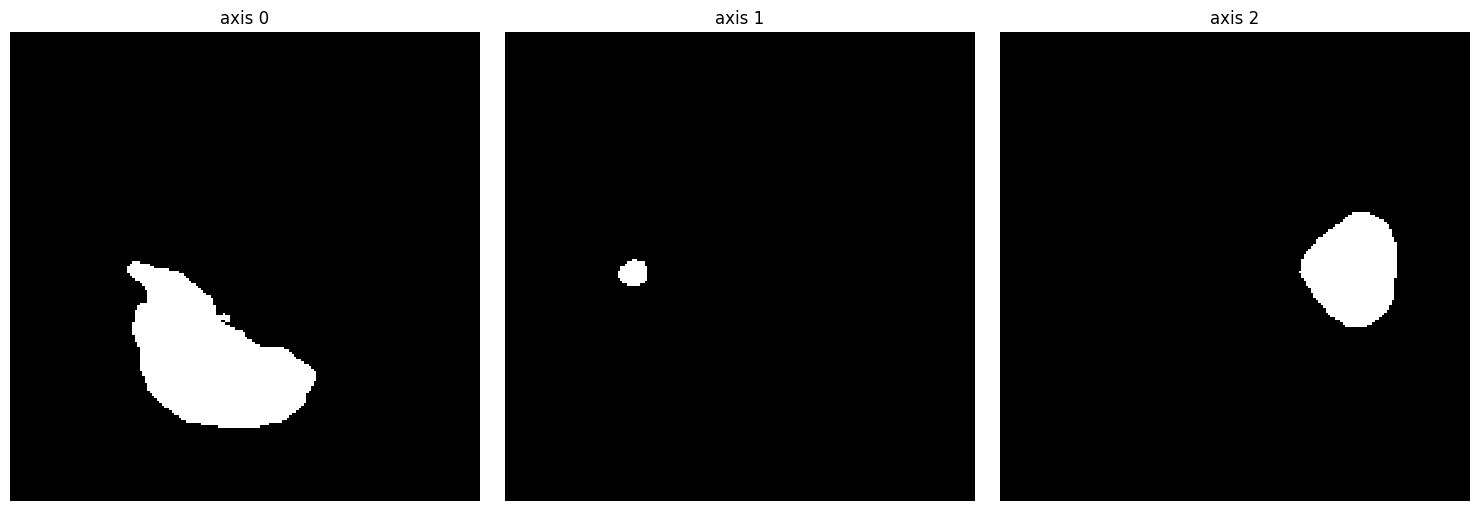

first step:  0.02912749502540344


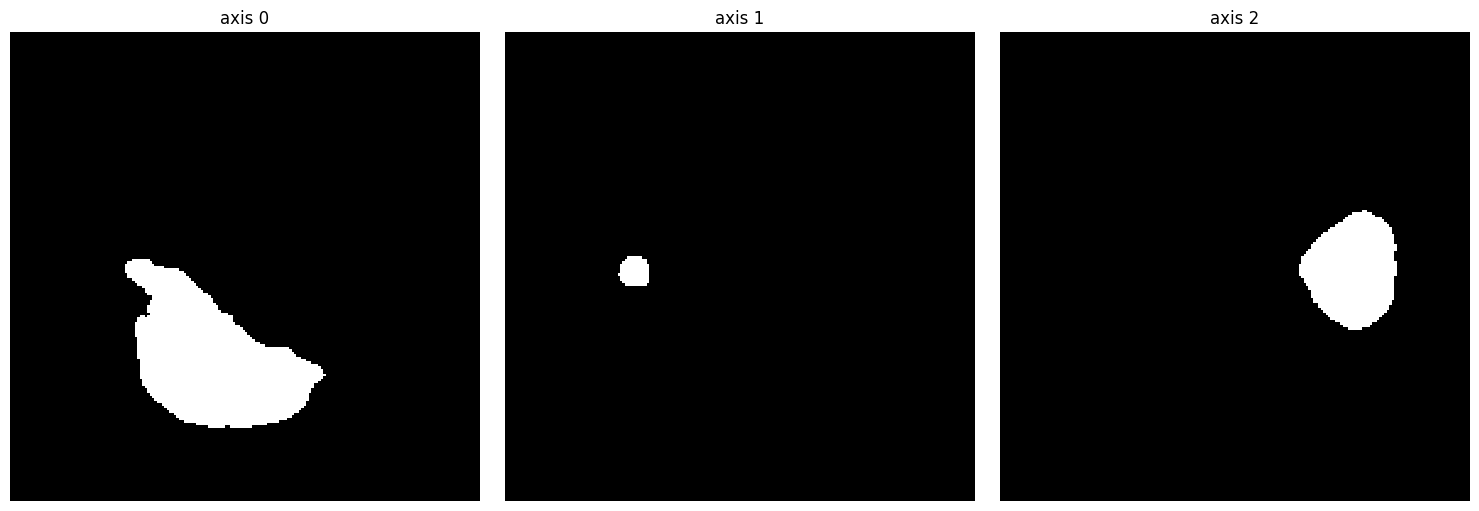

second step:  0.03049333194016868
## [0.703125   0.703125   0.69999886]
dilated image @@@@@@@@@@@@@@@@@@


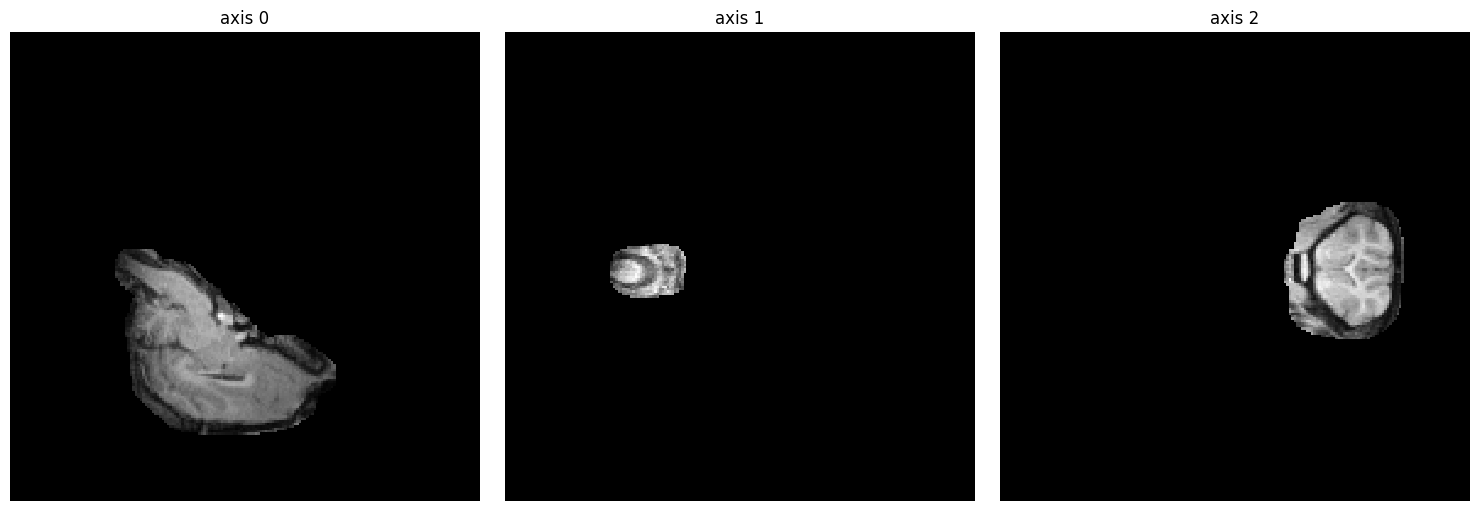

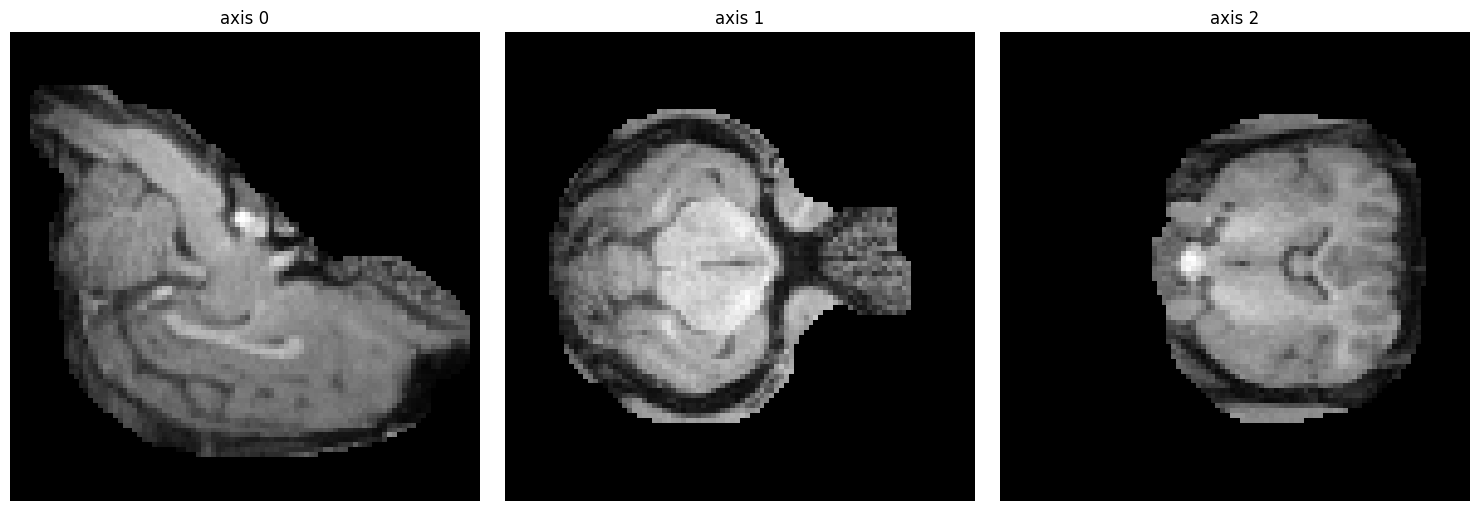

############# (96, 96, 96)
(96, 96, 96) ######


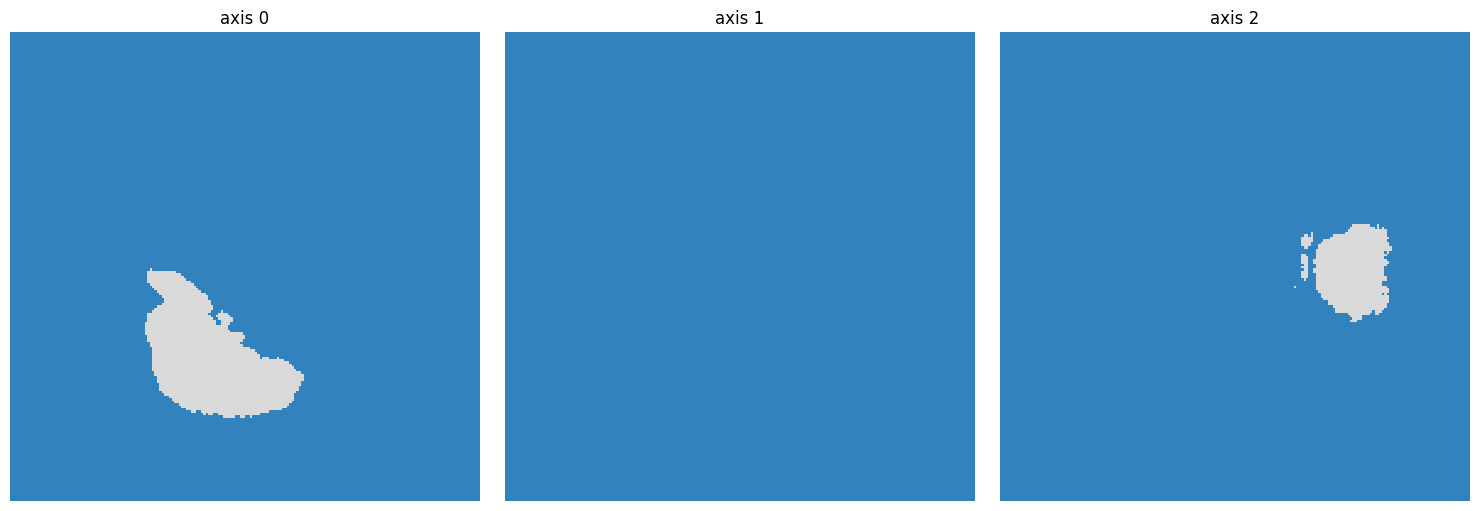

Dice coefficient for 2017_1_post: 0.0197
sadia/2017_2_post/image.nii.gz
[DEBUG] NiftiArrayIO.load(): no header extensions found!
(192, 192, 192)


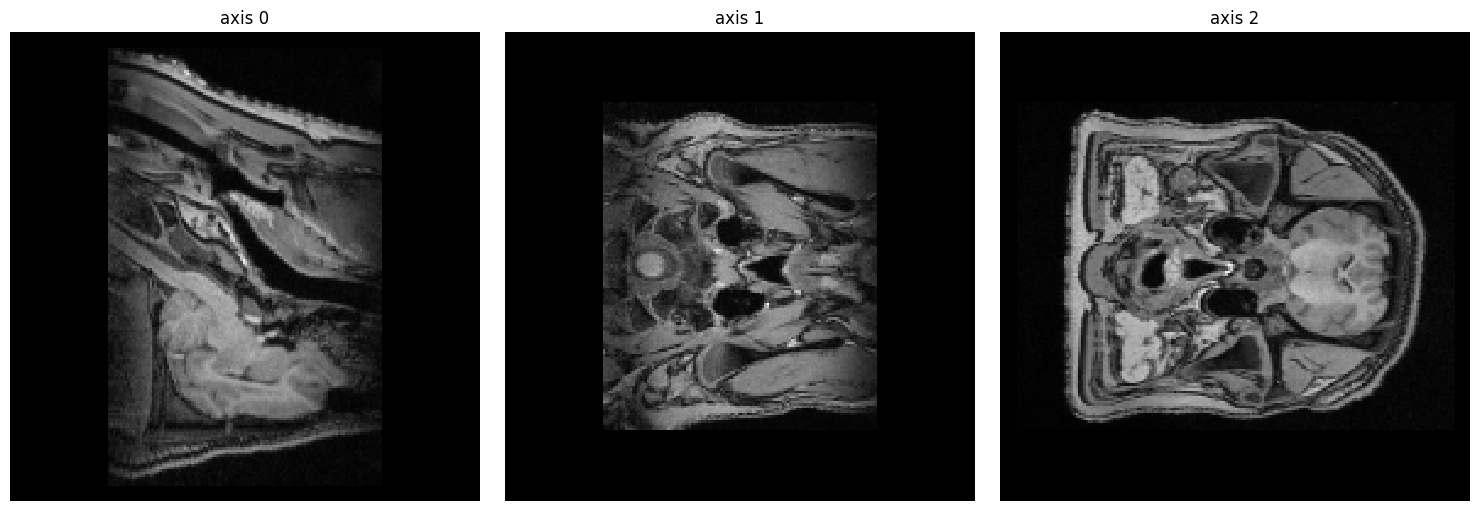

orig shape (192, 256, 160)
Initial Prediction Result:


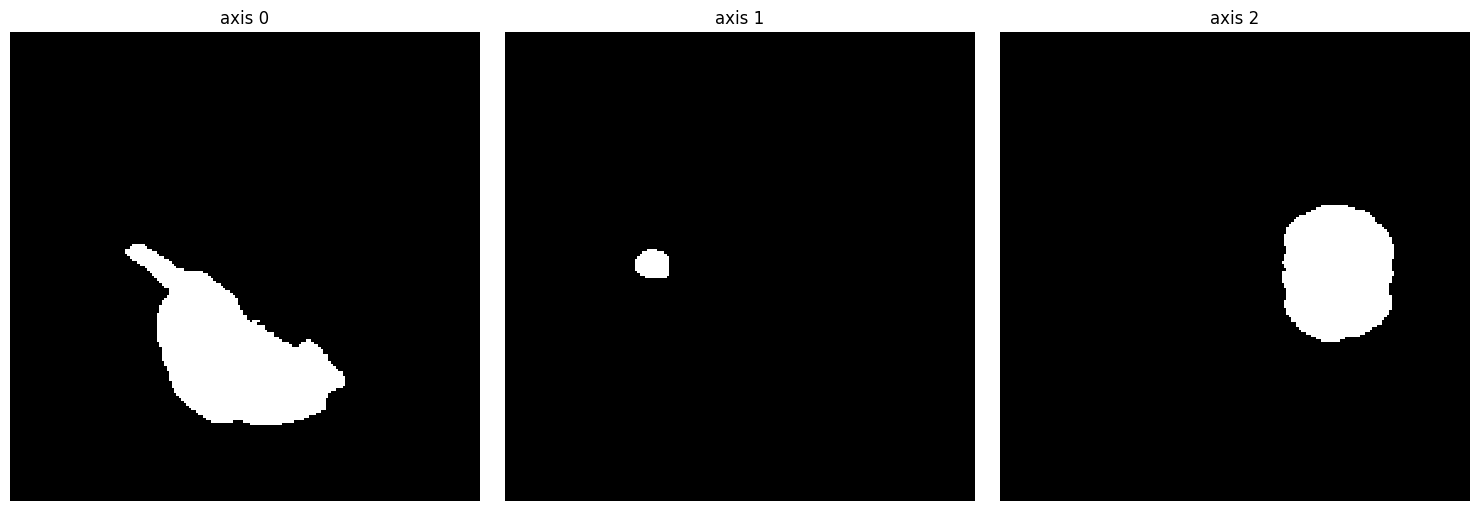

first step:  0.029771574593171177


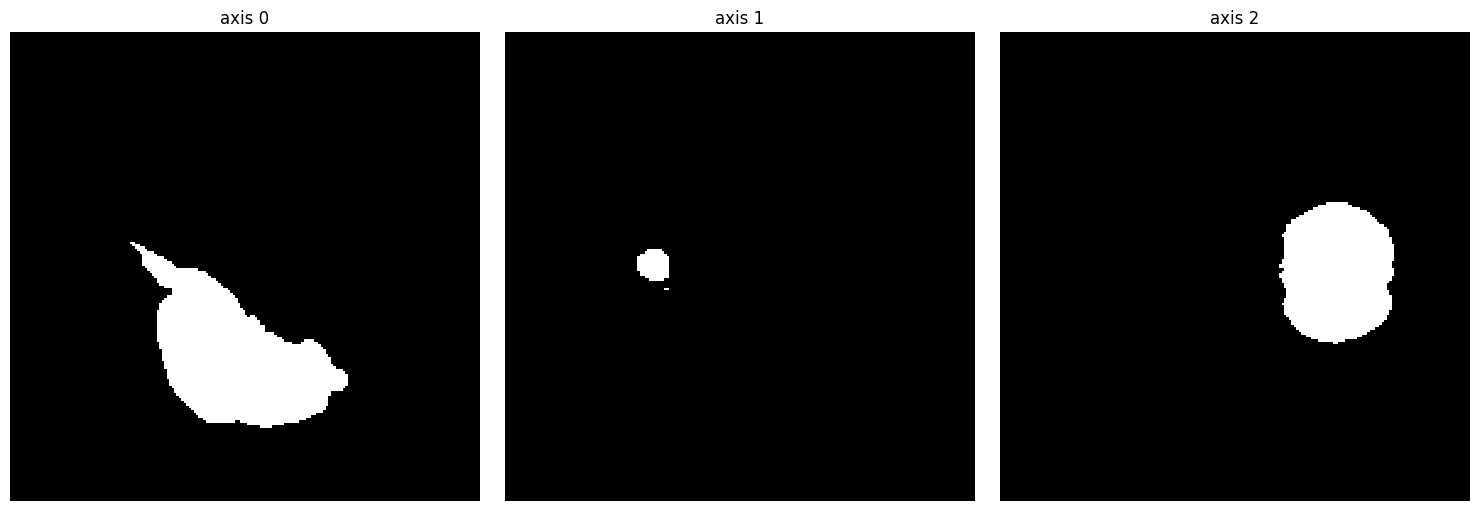

second step:  0.031031632792438018
## [0.703125   0.703125   0.70000076]
dilated image @@@@@@@@@@@@@@@@@@


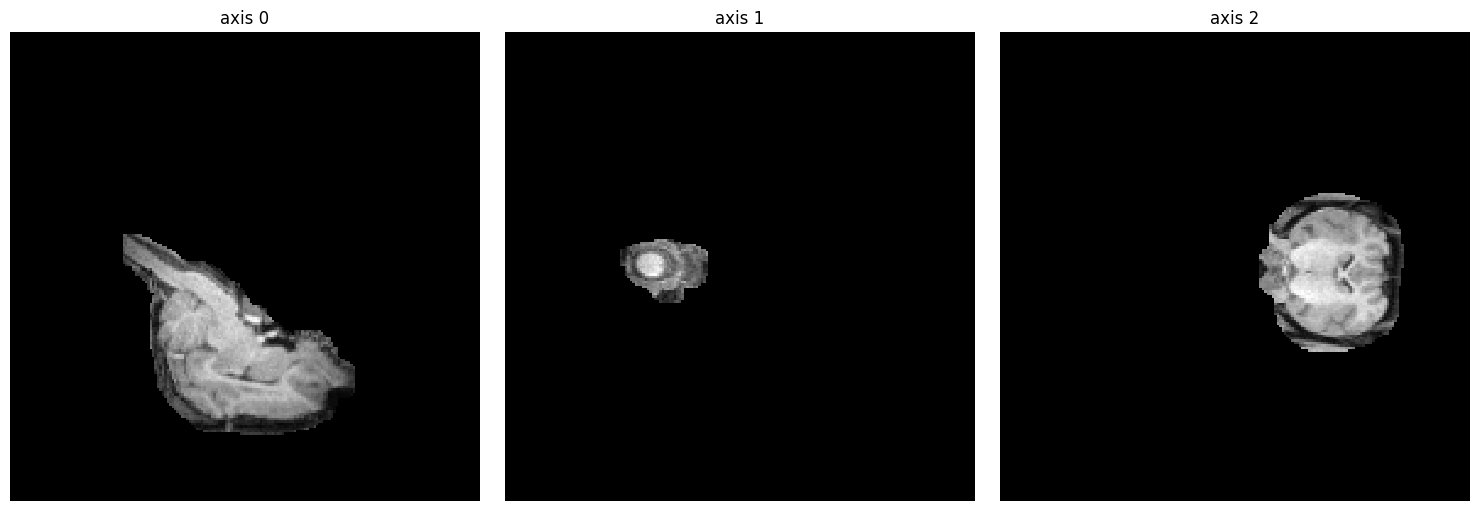

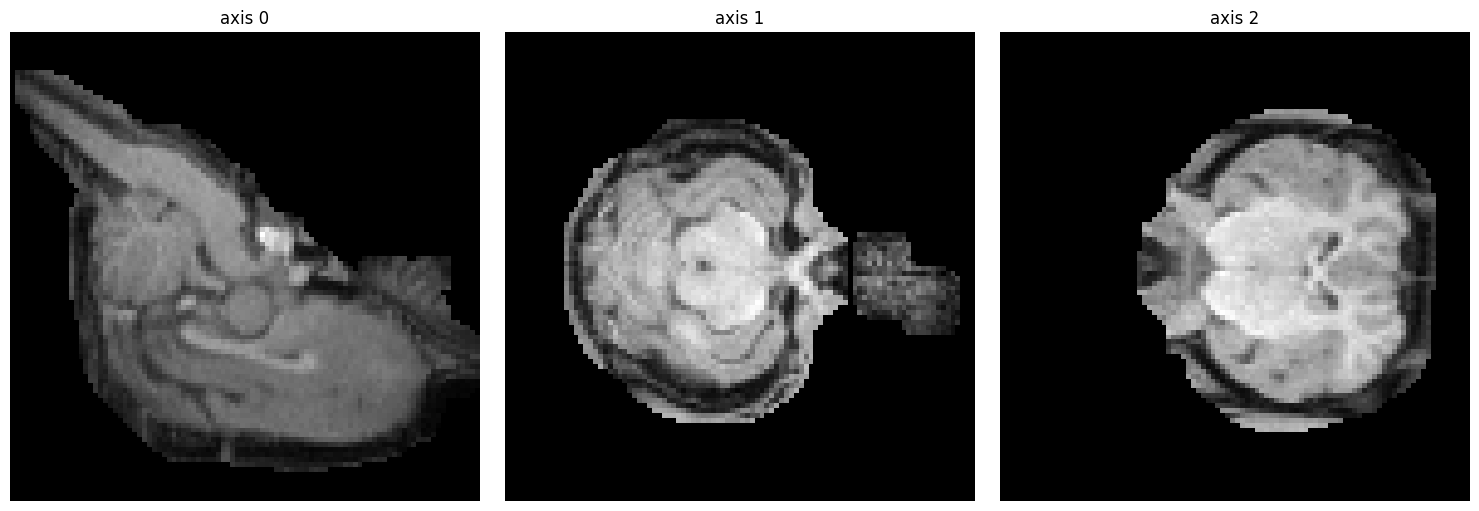

############# (96, 96, 96)
(96, 96, 96) ######


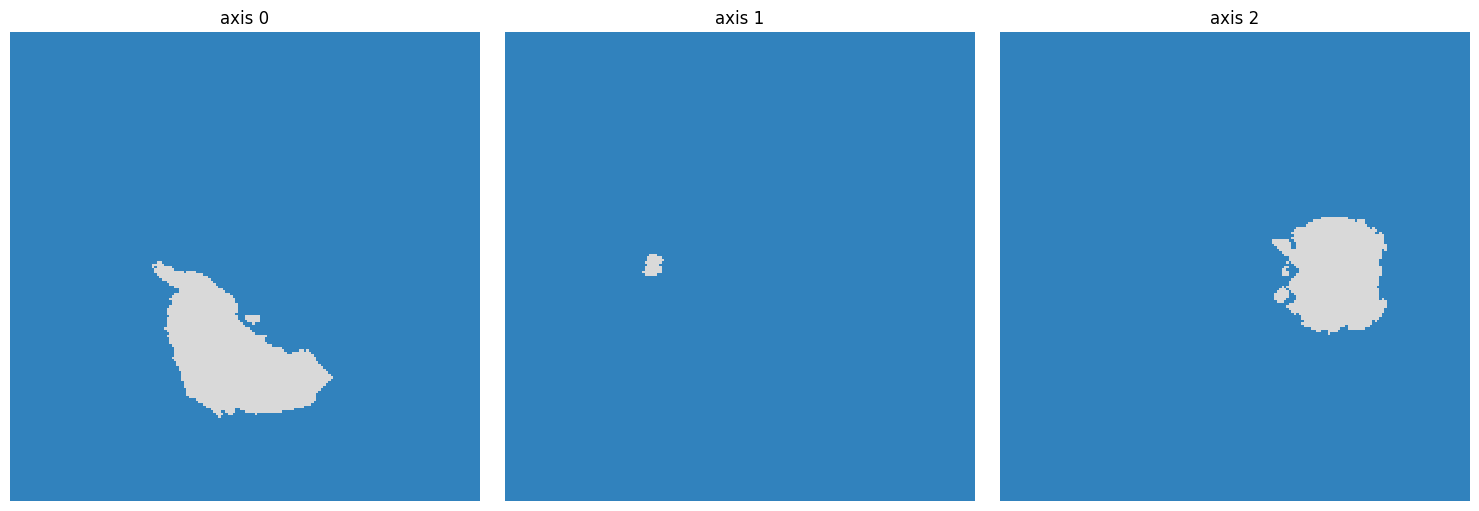

Dice coefficient for 2017_2_post: 0.0204
sadia/2016_13_post/image.nii.gz
[DEBUG] NiftiArrayIO.load(): no header extensions found!
(192, 192, 192)


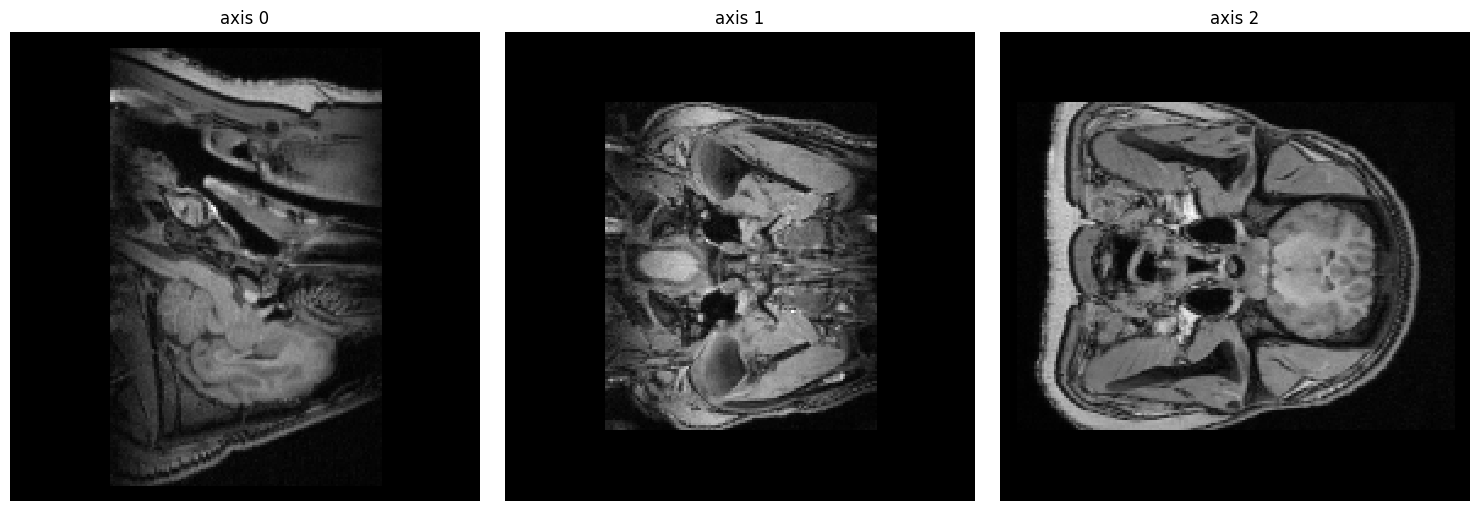

orig shape (192, 256, 160)
Initial Prediction Result:


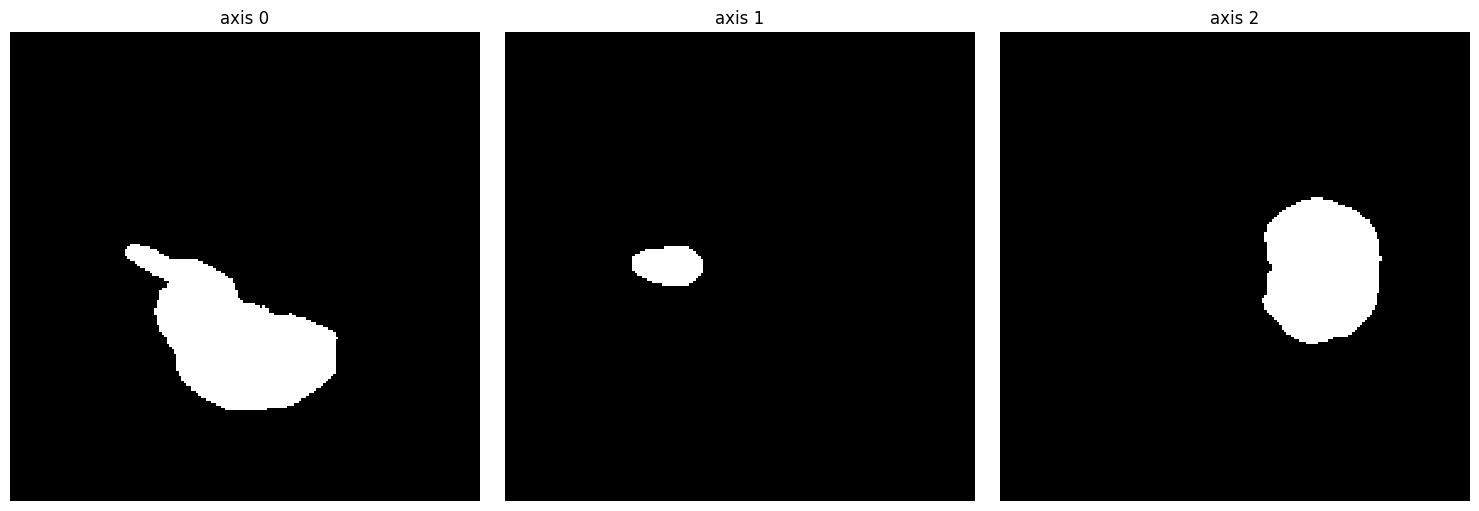

first step:  0.03217546889137968


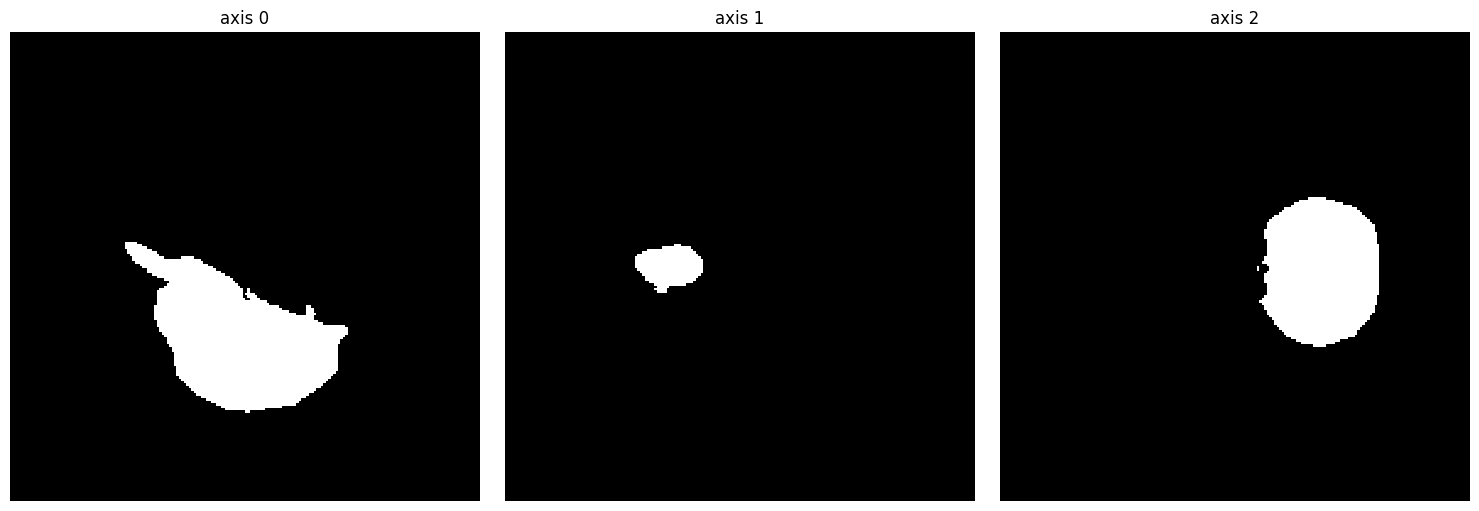

second step:  0.03427519555147049
## [0.703125  0.703125  0.6996994]
dilated image @@@@@@@@@@@@@@@@@@


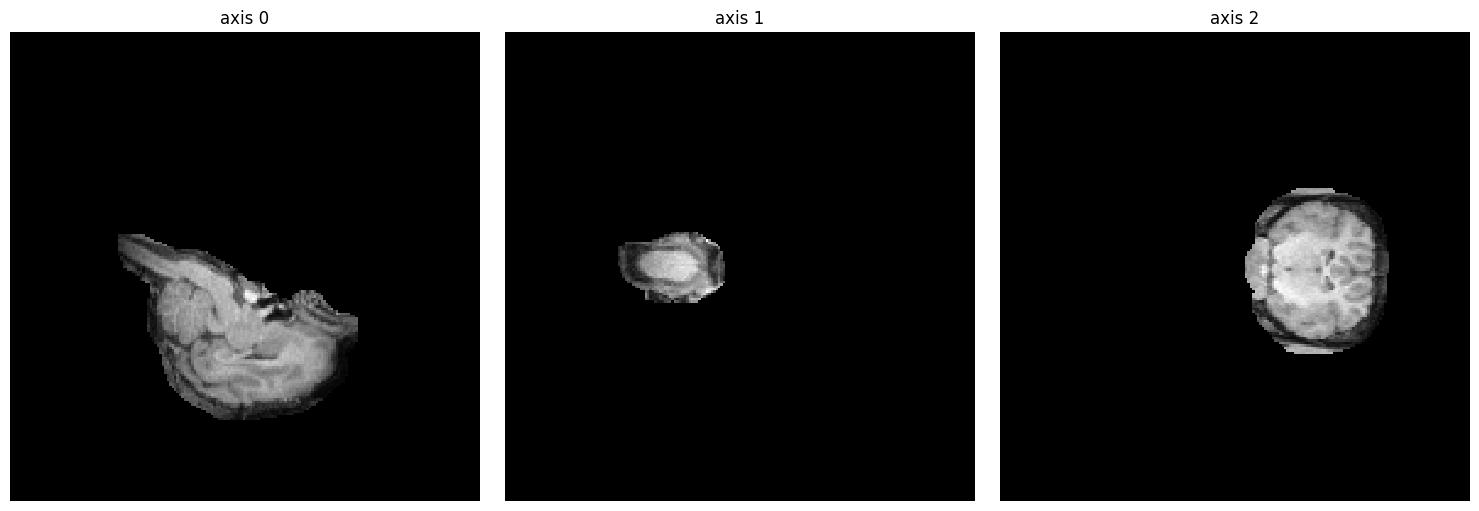

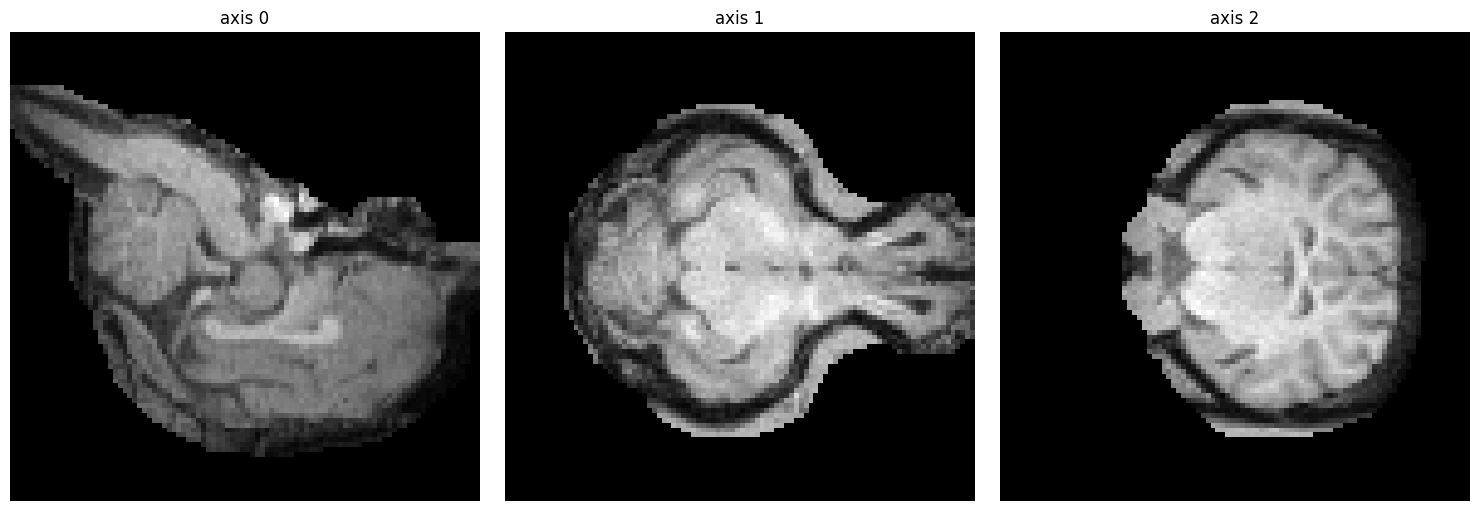

############# (96, 96, 96)
(96, 96, 96) ######


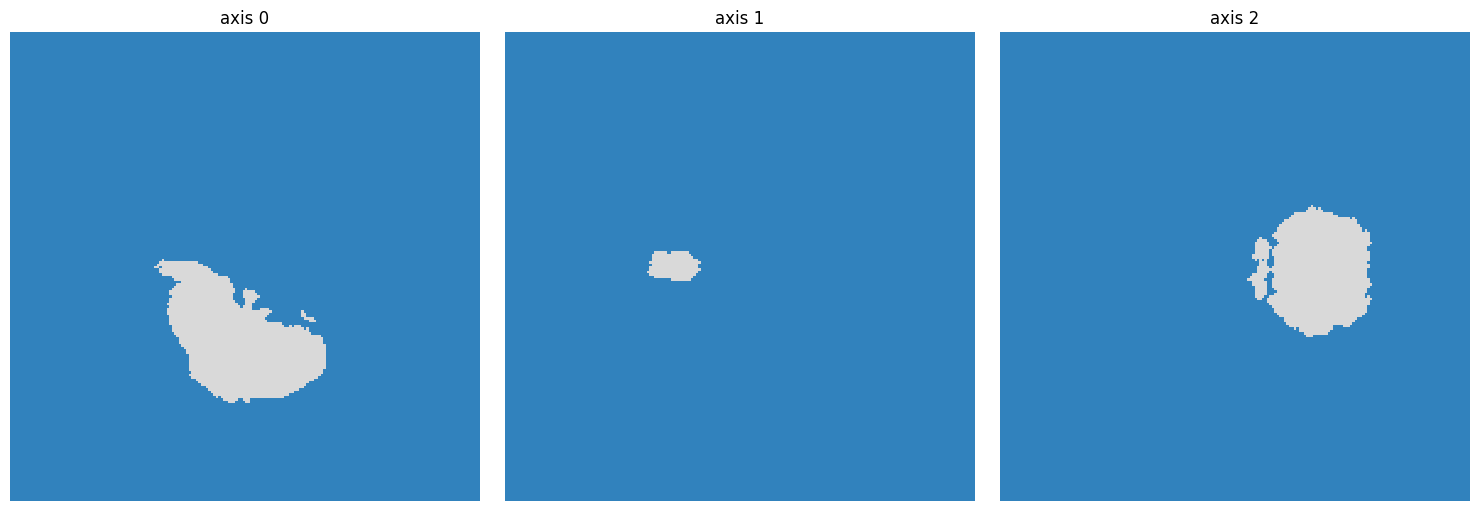

Dice coefficient for 2016_13_post: 0.0223
sadia/2016_5_post/image.nii.gz
[DEBUG] NiftiArrayIO.load(): no header extensions found!
(192, 192, 192)


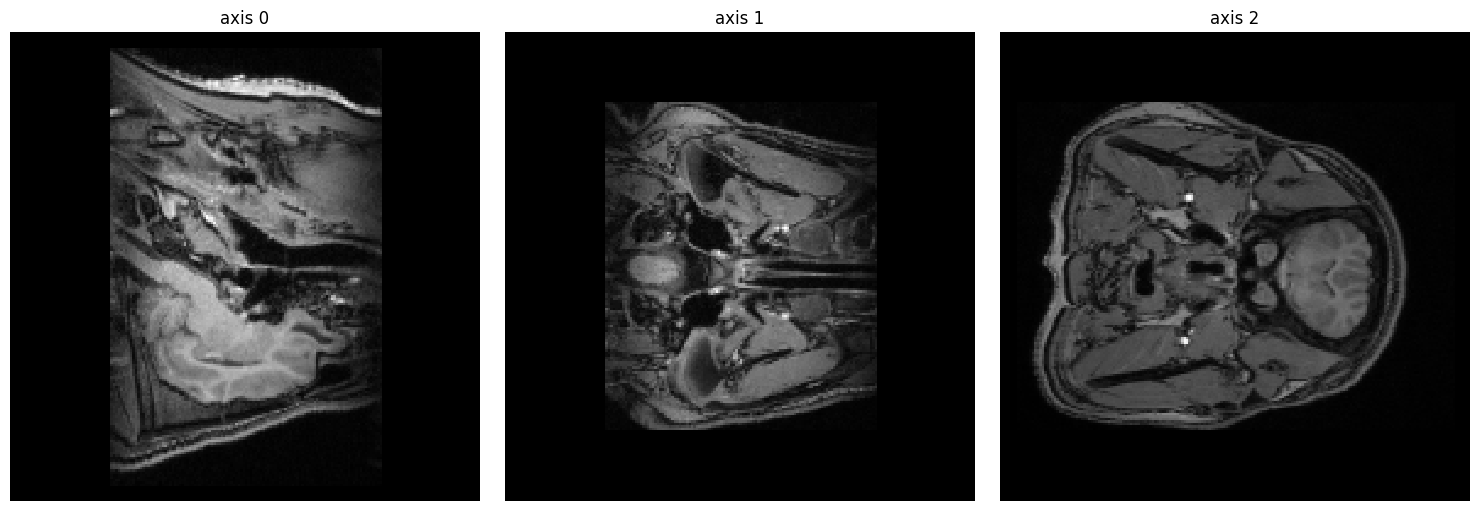

orig shape (192, 256, 160)
Initial Prediction Result:


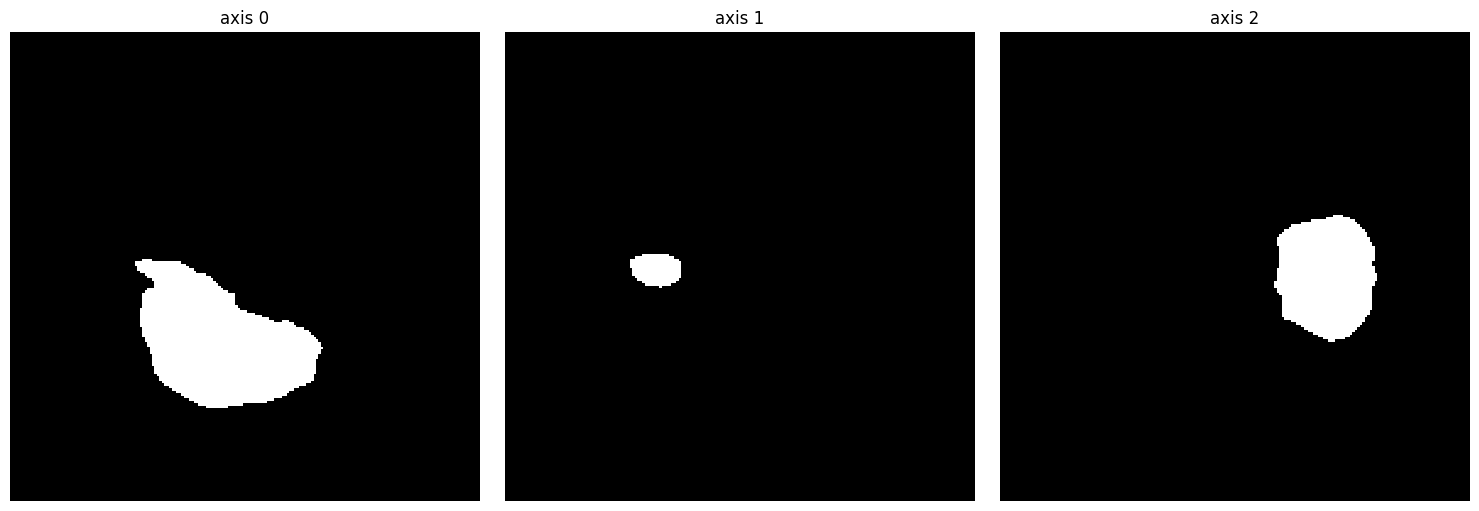

first step:  0.02925288763709724


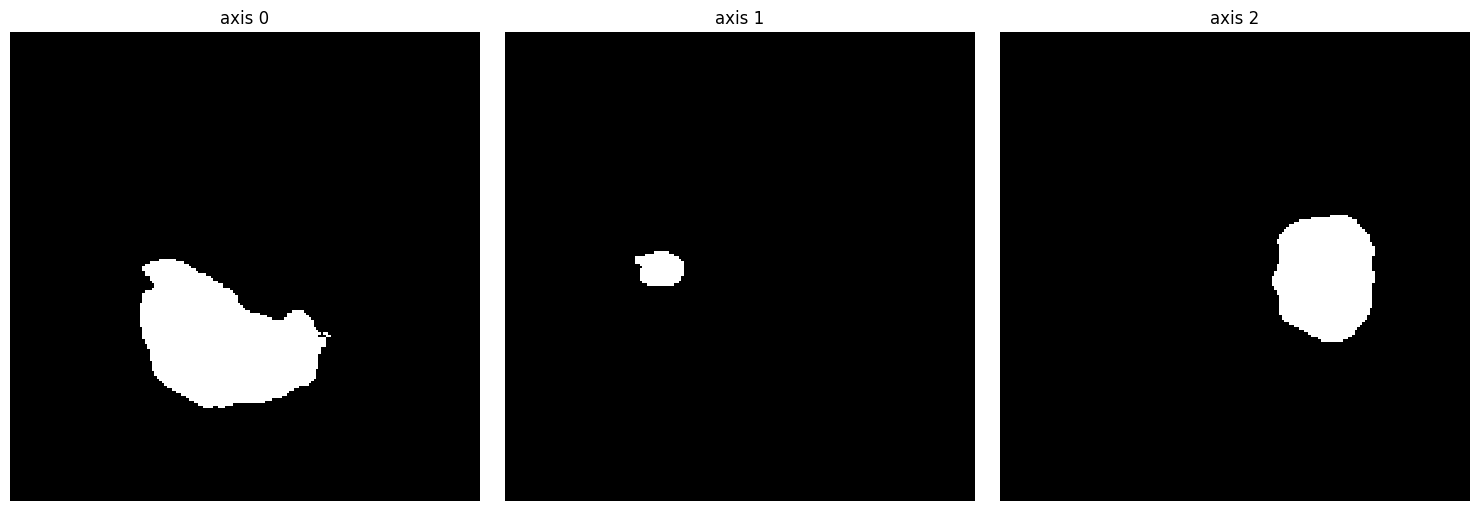

second step:  0.030832509472143197
## [0.703125   0.703125   0.69999886]
dilated image @@@@@@@@@@@@@@@@@@


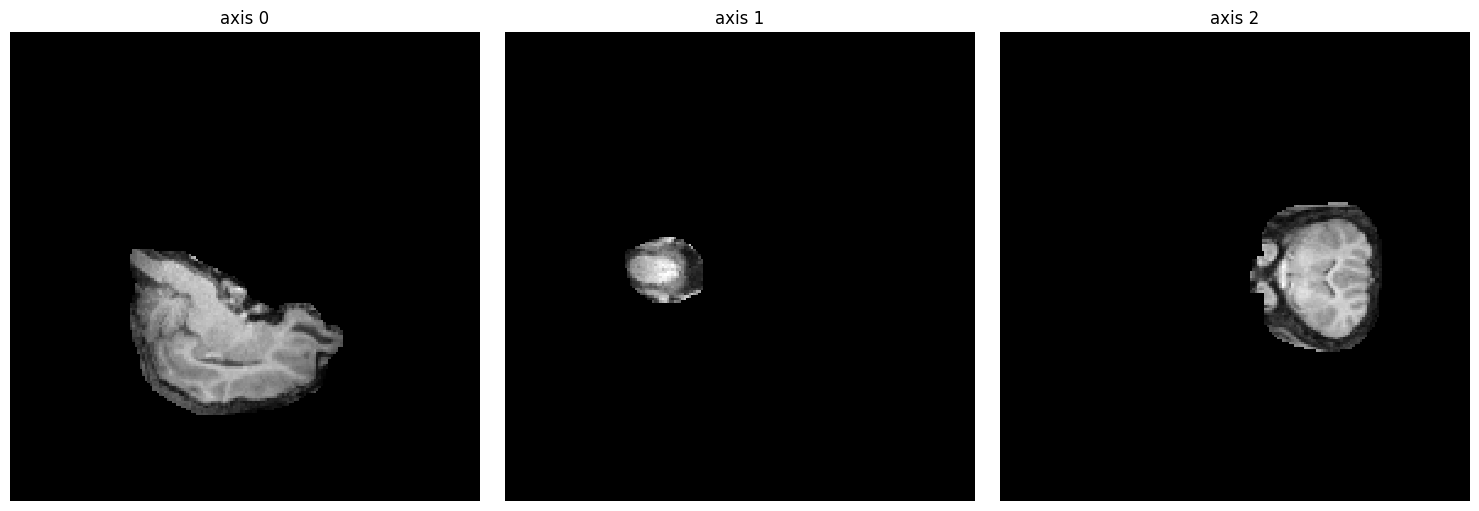

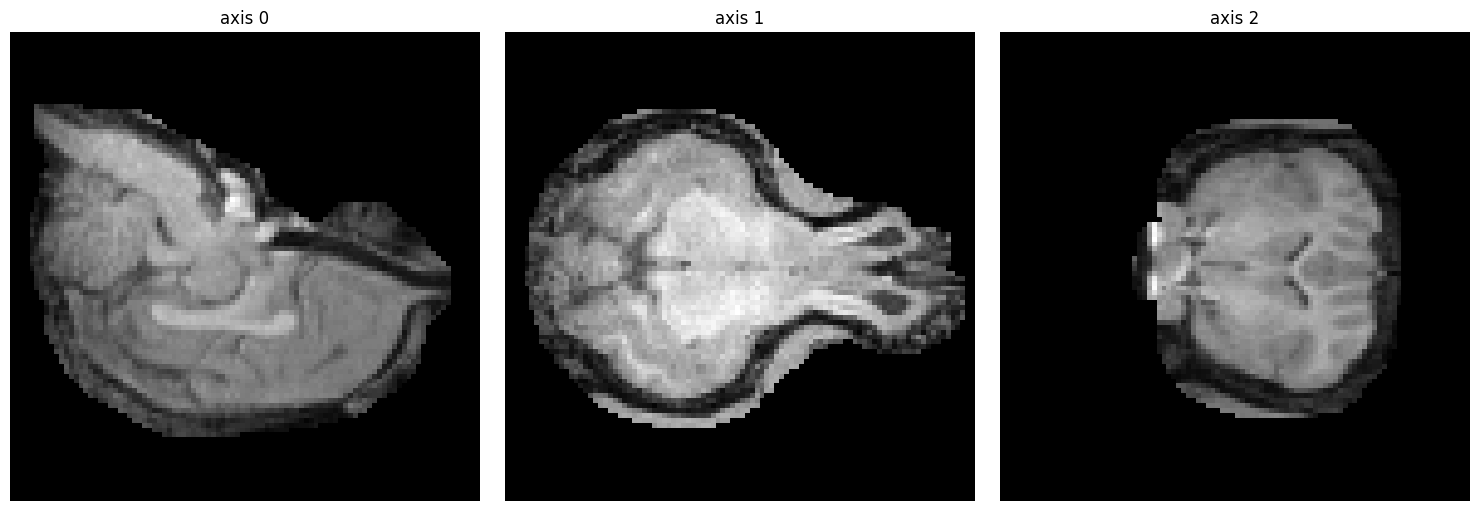

############# (96, 96, 96)
(96, 96, 96) ######


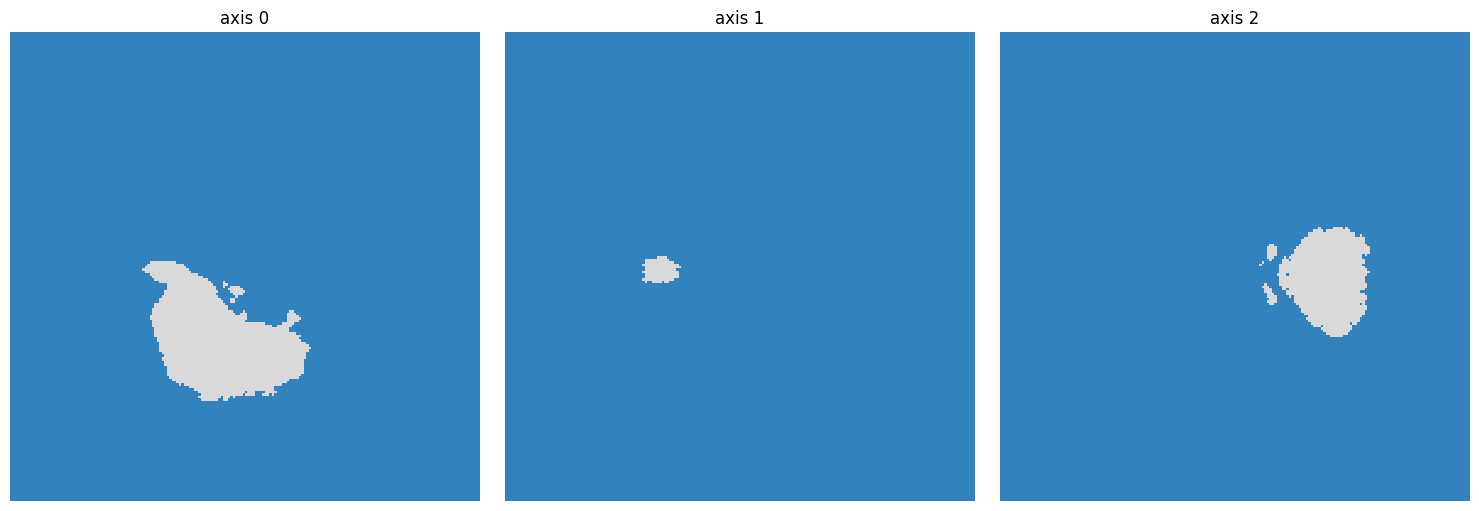

Dice coefficient for 2016_5_post: 0.0207
Overall Dice coefficient: 0.0208


In [4]:
import os
import numpy as np
import surfa as sf
import neurite as ne
from scipy import ndimage
from sklearn.metrics import jaccard_score
from utils import find_bounding_box, find_random_bounding_box, apply_gaussian_smoothing, extract_cube
import numpy as np
from scipy.ndimage import binary_dilation
from scipy.ndimage import zoom

import numpy as np
from sklearn.cluster import KMeans
from scipy.ndimage import binary_dilation

from scipy.ndimage import binary_dilation, binary_erosion
from sklearn.cluster import KMeans
import numpy as np

from scipy.ndimage import binary_erosion, binary_dilation, label
import numpy as np

from sklearn.decomposition import PCA

import numpy as np
from sklearn.decomposition import PCA
from scipy.ndimage import binary_dilation
import numpy as np
from scipy.ndimage import label



def fix_slicewise_midline_symmetry(mask, min_size=10, max_size=200, z_limit_ratio=0.3):
    """
    For each axial slice (Z), mirror small disconnected clusters across the midline to fill missing parts.

    Parameters:
        mask: np.ndarray (Z, Y, X), binary mask
        min_size: int, smallest cluster size to consider mirroring (filters noise)
        max_size: int, largest cluster size to consider (to only mirror olfactory-sized parts)
        z_limit_ratio: float, fraction of anterior slices to check (e.g., 0.3 = 30% front of brain)

    Returns:
        corrected_mask: np.ndarray, updated mask with slice-wise symmetry fix
    """
    Z, Y, X = mask.shape
    mid_x = X // 2
    z_limit = int(Z * z_limit_ratio)
    corrected = mask.copy()

    for z in range(z_limit):  # only anterior slices
        slice_mask = mask[z]
        labeled, num = label(slice_mask)
        
        for i in range(1, num + 1):
            component = (labeled == i)
            size = np.sum(component)
            if not (min_size <= size <= max_size):
                continue

            ys, xs = np.where(component)
            x_mean = np.mean(xs)
            mirrored_xs = (2 * mid_x - xs).astype(int)
            mirrored_coords = np.stack([ys, mirrored_xs], axis=1)

            # Filter valid pixels
            valid = (mirrored_coords[:, 1] >= 0) & (mirrored_coords[:, 1] < X)
            mirrored_coords = mirrored_coords[valid]

            for yx in mirrored_coords:
                y, x = yx
                if corrected[z, y, x] == 0:  # only fill missing parts
                    corrected[z, y, x] = 1

    return corrected


def estimate_midline(mask):
    """
    Estimate sagittal midline index that best splits the mask into equal halves.

    Parameters:
        mask: np.ndarray (Z, Y, X), binary mask of the brain

    Returns:
        mid_x: int, estimated mid-sagittal plane index
    """
    _, _, X = mask.shape
    balance_scores = []
    for x in range(X):
        left = mask[:, :, :x].sum()
        right = mask[:, :, x:].sum()
        balance_scores.append(abs(left - right))
    mid_x = np.argmin(balance_scores)
    return mid_x


def trim_outer_rings(mask, erosion_iters=1, min_size=1000):
    """
    Removes thin outer rings and small noisy components from a binary mask.

    Parameters:
        mask: np.ndarray, binary mask to be cleaned
        erosion_iters: int, how much to shrink outer parts
        min_size: int, minimum allowed component size to keep

    Returns:
        cleaned_mask: np.ndarray, binary mask with outer noise removed
    """
    # Erode to remove outer fringes
    eroded = binary_erosion(mask, iterations=erosion_iters)

    # Label connected regions
    labeled_mask, num_features = label(eroded)

    # Keep only large regions
    cleaned_mask = np.zeros_like(mask)
    for i in range(1, num_features + 1):
        region = (labeled_mask == i)
        if np.sum(region) > min_size:
            cleaned_mask |= region

    # Dilate back to approximate original shape (optional)
    cleaned_mask = binary_dilation(cleaned_mask, iterations=erosion_iters)
    return cleaned_mask.astype(np.uint8)


def extract_brain_mask(crop_img, initial_mask, n_clusters=3, skull_threshold=100, erosion_margin=5):
    """
    Refines an initial binary brain mask assuming inner mask is mostly correct,
    and outer boundary (~5 voxels) may contain misclassified regions.

    Parameters:
        crop_img: np.ndarray (Z, Y, X), grayscale brain scan
        initial_mask: np.ndarray (Z, Y, X), binary mask (1=brain, 0=non-brain)
        n_clusters: int, number of intensity clusters
        skull_threshold: float, intensity threshold to ignore background
        erosion_margin: int, how deep to erode for trusted core

    Returns:
        refined_mask: np.ndarray, corrected binary mask
    """
    # Trusted core (eroded)
    eroded_mask = binary_erosion(initial_mask, iterations=erosion_margin)
    trusted_core = eroded_mask.astype(np.uint8)

    # Uncertain shell (outer 5 voxels)
    dilated_mask = binary_dilation(initial_mask, iterations=erosion_margin)
    uncertain_shell = (dilated_mask & ~eroded_mask) & (crop_img > skull_threshold)

    # Only cluster the uncertain shell
    voxel_values = crop_img[uncertain_shell].reshape(-1, 1)
    if voxel_values.size == 0:
        return initial_mask.astype(np.uint8)

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(voxel_values)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_.flatten()

    # Choose the cluster most similar to trusted core (based on mean intensity)
    core_values = crop_img[trusted_core.astype(bool)]
    core_mean = np.mean(core_values)
    brain_label = np.argmin(np.abs(centers - core_mean))

    # Create new brain region from classified shell
    shell_mask = np.zeros_like(initial_mask, dtype=np.uint8)
    shell_mask[uncertain_shell] = (labels == brain_label).astype(np.uint8)

    # Combine shell and core
    refined_mask = np.logical_or(trusted_core, shell_mask).astype(np.uint8)
    refined_mask = trim_outer_rings(refined_mask)
    return refined_mask




import numpy as np
from scipy.ndimage import binary_dilation, binary_erosion


# Define a 3D structuring element (e.g., 3x3x3 cube)
structure = np.ones((3, 3, 3), dtype=bool)


validation_folder_path = "sadia"
save_folder_path = "sadia"

# validation_folder_path = "/gpfs/fs001/cbica/home/broodman/Pig_project"

subfolders = [f.name for f in os.scandir(validation_folder_path) if f.is_dir()]
combined_model = get_pig_model(k1,k2)
combined_model_128 = get_pig_model_128()

import numpy as np

def majority_vote_mask(mask1, mask2, mask3):
    """
    Performs majority voting on three binary masks.
    Voxels with values above 1 in the sum of the masks will be set to 1, others will be set to 0.
    
    Parameters:
    - mask1 (ndarray): First binary mask (same shape as the others).
    - mask2 (ndarray): Second binary mask (same shape as the others).
    - mask3 (ndarray): Third binary mask (same shape as the others).
    
    Returns:
    - final_mask (ndarray): A binary mask where the majority rule is applied.
    """
    # Sum the three masks element-wise
    combined_sum = mask1 + mask2 + mask3
    
    # Apply majority voting: voxels where sum > 1 are set to 1, else 0
    final_mask = (combined_sum > 1).astype(np.int32)
    
    return final_mask

def fill_holes_per_class(mask, labels=None):
    filled_mask = np.zeros_like(mask)
    if labels is None:
        labels = np.unique(mask)
        labels = labels[labels != 0]  # skip background

    for label in labels:
        class_mask = (mask == label)
        filled_class = ndi.binary_fill_holes(class_mask)
        filled_mask[filled_class] = label

    return filled_mask

from scipy.ndimage import binary_dilation, binary_erosion

def fill_holes_by_dilate_erode(mask, iterations=2):
    filled_mask = np.zeros_like(mask)
    labels = np.unique(mask)
    labels = labels[labels != 0]  # Skip background

    for label in labels:
        binary = (mask == label)
        # Dilate first to close small holes
        dilated = binary_dilation(binary, iterations=iterations)
        # Erode to restore the shape
        cleaned = binary_erosion(dilated, iterations=iterations)
        filled_mask[cleaned] = label

    return filled_mask

import numpy as np
from scipy.ndimage import binary_erosion, binary_dilation




from sklearn.cluster import KMeans
import numpy as np



def smooth_mask_by_erode_dilate(mask, iterations=2):
    """
    Applies morphological opening (erosion followed by dilation) to each label in the mask.

    Parameters:
        mask: 2D or 3D np.ndarray of labeled regions (0 = background)
        iterations: number of pixels/voxels to erode and then dilate

    Returns:
        smoothed_mask: mask with each label processed separately
    """
    smoothed_mask = np.zeros_like(mask)
    labels = np.unique(mask)
    labels = labels[labels != 0]  # Skip background

    for label in labels:
        binary = (mask == label)
        # Erode first to remove small bumps
        eroded = binary_erosion(binary, iterations=iterations)
        # Then dilate to restore general shape
        cleaned = binary_dilation(eroded, iterations=iterations)
        smoothed_mask[cleaned] = label

    return smoothed_mask
def refine_prediction2(crop_img,image, mask, model, model_128,model_96, folder, new_image_size=(192, 192, 192), margin=0, cube_size=128):
    """
    Refines the segmentation prediction in two steps:
    1. Makes an initial prediction.
    2. Crops the image based on the prediction and runs the model again.
    
    Parameters:
    - crop_img (ndarray): The input image for prediction.
    - mask (ndarray): The binary mask.
    - model: The trained segmentation model.
    - new_image_size (tuple): The new voxel size for resizing (default is (192, 192, 192)).
    - margin (int): The margin to add around the bounding box (default is 10).
    - cube_size (int): The size of the bounding cube (default is 32).
    
    Returns:
    - final_prediction_resized (ndarray): The final refined prediction, resized to match the original input size.
    """

    orig_shape = image.shape
    voxsize = image.geom.voxsize
    folder_path = os.path.join(save_folder_path, folder)
    os.makedirs(folder_path, exist_ok=True)
    affine = np.array(image.geom.vox2world)
    # nib.save(nib.Nifti1Image(image.data, affine), os.path.join(folder_path, 'image.nii.gz'))
    
    # Step 1: Initial Prediction
    # Binarize the mask
    mask.data[mask.data != 0] = 1
    # nib.save(nib.Nifti1Image(mask.astype(np.int32), image.geom.vox2world), os.path.join(folder_path, 'mask.nii.gz'))

    # Compute mask center (using the provided find_bounding_box function)
    ms = np.mean(np.column_stack(np.nonzero(mask)), axis=0).astype(int)
    print(crop_img.shape)
    
    # Make an initial prediction
    prediction_one_hot = model.predict(crop_img[None, ...], verbose=0)
    initial_prediction = np.argmax(prediction_one_hot, axis=-1)[0]
    ne.plot.volume3D(crop_img, slice_nos=ms)
    print("orig shape",orig_shape)
    print("Initial Prediction Result:")

    labeled, num_components = ndimage.label(initial_prediction > 0)
    largest_mask = labeled == np.argmax(ndimage.sum(initial_prediction > 0, labeled, range(num_components + 1)))
    initial_prediction = ndi.binary_fill_holes(largest_mask)
    initial_prediction = (initial_prediction > 0).astype(np.int32)
    nib.save(nib.Nifti1Image(sf.Volume(initial_prediction.astype(np.int32)).resize(voxsize,method="nearest")
                             .reshape(orig_shape).data, affine), os.path.join(folder_path, 'initial_prediction.nii.gz'))

    ne.plot.volume3D(initial_prediction, slice_nos=ms)
    print("first step: ",my_hard_dice(mask.data, initial_prediction))

    # Step 2: Use find_bounding_box function to get the bounding box
    x1, y1, z1, x2, y2, z2 = find_bounding_box(initial_prediction, cube_size=cube_size)
    cube = extract_cube(crop_img, x1, y1, z1, x2, y2, z2, cube_size=128)


    pred_192_1 = np.zeros((192,192,192))
    pred_192_2 = np.zeros((192,192,192))
    
    ms = np.mean(np.column_stack(np.nonzero(mask)), axis=0).astype(int)
    # ne.plot.volume3D(cube, slice_nos=ms)

    # Step 3: Re-run the Model with the cropped image
    prediction_cropped_one_hot = model_128.predict(cube[None, ...], verbose=0)
    final_prediction = np.argmax(prediction_cropped_one_hot, axis=-1)[0]
    pred_192_1[x1:x2, y1:y2, z1:z2] = final_prediction
    pred_192_1[pred_192_1==1]=1
    
    labeled, num_components = ndimage.label(pred_192_1 > 0)
    largest_mask = labeled == np.argmax(ndimage.sum(pred_192_1 > 0, labeled, range(num_components + 1)))
    largest_mask = ndi.binary_fill_holes(largest_mask)
    pred_192_1 = largest_mask
    pred_192_1 = (pred_192_1 > 0).astype(np.int32)
    ne.plot.volume3D(pred_192_1, slice_nos=ms)
    print("second step: ",my_hard_dice(mask.data, pred_192_1))
    pred_192_1_before_dialation = pred_192_1
    print("##",voxsize)
    pred_192_1 = binary_dilation(pred_192_1, structure=structure, iterations=dial_param)
    crop_img = crop_img*(pred_192_1>0)



    # nib.save(nib.Nifti1Image(sf.Volume(crop_img.resize(voxsize,method="nearest").reshape(orig_shape).data, affine), os.path.join("synth_data", 'dialated_image.nii.gz')))
    print("dilated image @@@@@@@@@@@@@@@@@@")
    ne.plot.volume3D(crop_img, slice_nos=ms)
    
    x1, y1, z1, x2, y2, z2 = find_bounding_box(pred_192_1, cube_size=96)
    cube = extract_cube(crop_img, x1, y1, z1, x2, y2, z2, cube_size=96)

    # else:
    zoom_in_factor = 1
    cube_zoomed = zoom(cube, zoom=zoom_in_factor, order=1)  # linear interpolation
    cube_zoomed = sf.Volume(cube_zoomed).reshape((96,96,96))
    ne.plot.volume3D(cube_zoomed)
    print("#############",cube_zoomed.shape)
    # ne.plot.volume3D(cube_zoomed, slice_nos=ms)
    prediction_cropped_one_hot = model_96.predict(cube_zoomed[None, ..., None], verbose=0)
    pred_96 = np.argmax(prediction_cropped_one_hot, axis=-1)[0]
    zoom_out_factor = 1
    pred_96_zoomed_out = zoom(pred_96, zoom=zoom_out_factor, order=0)  # nearest neighbor for labels
    print(pred_96_zoomed_out.shape,"######")
    pred_192_2[x1:x2, y1:y2, z1:z2] = sf.Volume(pred_96_zoomed_out).reshape((96,96,96)).data
    pred_192_2 = np.where(pred_192_2 == 2, 2, initial_prediction)
    pred_192_2 = extract_brain_mask(crop_img.data,pred_192_2)
    
    if atlas:
        crop_img = crop_img*(pred_192_2>0)
        zoom_in_factor = 2
        cube_zoomed = zoom(crop_img, zoom=zoom_in_factor, order=1)  # linear interpolation
        cube_zoomed = sf.Volume(cube_zoomed).reshape((192,192,192))
        ne.plot.volume3D(cube_zoomed)
        print("#############",cube_zoomed.shape)
        # ne.plot.volume3D(cube_zoomed, slice_nos=ms)
        prediction_cropped_one_hot = combined_model_seg.predict(cube_zoomed[None, ..., None], verbose=0)
        pred_192 = np.argmax(prediction_cropped_one_hot, axis=-1)[0]
        zoom_out_factor = 0.5
        pred_96_zoomed_out = zoom(pred_192, zoom=zoom_out_factor, order=0)
        
        pred_192_2 = sf.Volume(pred_96_zoomed_out).reshape((192,192,192)).data

    ne.plot.volume3D(pred_192_2, slice_nos=ms,cmaps=['tab20c'])
    nib.save(nib.Nifti1Image(sf.Volume(pred_192_2.astype(np.int32)).resize(voxsize,method="nearest").reshape(orig_shape).data, affine), os.path.join(folder_path, 'second_prediction.nii.gz'))
    # int("third step: ",my_hard_dice(mask.data, pred_192))

    crop_img = crop_img*(pred_192_2>0)
    nib.save(nib.Nifti1Image(sf.Volume(crop_img.astype(np.float32)).resize(voxsize,method="nearest").reshape(orig_shape).data, affine), os.path.join(folder_path, 'brain.nii.gz'))

    # nib.save(nib.Nifti1Image(sf.Volume(pred_192.astype(np.int32)).resize(voxsize,method="nearest").reshape(orig_shape).data, affine), os.path.join(folder_path, 'third_prediction.nii.gz'))
    return pred_192_2

# Store Dice coefficients
dice_scores = []

new_voxsize = [1, 1, 1]

import numpy as np
for folder in subfolders:
    folder_path = os.path.join(validation_folder_path, folder)
    folder_name = os.path.basename(folder_path)
        
    filename = os.path.join(folder_path, f"{folder_name}_T1.nii.gz")
    mask_filename = os.path.join(folder_path, f"{folder_name}_T1_mask.nii.gz")

    filename = os.path.join(folder_path, f"image.nii.gz")
    mask_filename = os.path.join(folder_path, f"mask.nii.gz")


    # if "JAW-106_pre" not in filename:
    #     continue
    # if "JAW-106_6month" in filename:
    #     print("NO MASK FOUND")
    #     continue
        
    print(filename)
    


    # Skip if no input file
    if not os.path.isfile(filename):
        continue
        
    # Load and process image
    image = sf.load_volume(filename)
    crop_img = image.resize(new_voxsize, method="linear").reshape([192, 192, 192, 1])
    orig_shape = image.shape
    orig_voxsize=crop_img.geom.voxsize

    # Binarize the mask
    

        # Load mask
    if not os.path.isfile(mask_filename):
        mask = sf.Volume(np.ones((192, 192, 192)))
    else:
        folder_path_2 = os.path.join("results", folder)
        mask = sf.load_volume(mask_filename).reshape(orig_shape)#resize(new_voxsize, method="linear")
        affine = np.array(image.geom.vox2world)
        print("mask shape",mask.shape,"image shape",image.shape)
        nib.save(nib.Nifti1Image(mask.astype(np.int32), affine), os.path.join(folder_path_2, 'mask.nii.gz'))
        mask = mask.resize(new_voxsize).reshape([192, 192, 192, 1])
        
    mask.data[mask.data != 0] = 1

    ms = np.mean(np.column_stack(np.nonzero(mask)), axis=0).astype(int)
    
    prediction = refine_prediction2(crop_img, image, mask, combined_model,combined_model_128,combined_model_96, folder, new_image_size=(192, 192, 192))

    # Compute Dice coefficient
    mask_flat = mask.data.flatten()
    prediction_flat = prediction.flatten()>0
    dice_score = 2 * np.sum(mask_flat * prediction_flat) / (np.sum(mask_flat) + np.sum(prediction_flat))
    if np.sum(mask.data)<1000:
        continue
    dice_scores.append(dice_score)

    print(f"Dice coefficient for {folder_name}: {dice_score:.4f}")
    # break

# Overall Dice coefficient and visualization
overall_dice = np.mean(dice_scores)
print(f"Overall Dice coefficient: {overall_dice:.4f}")




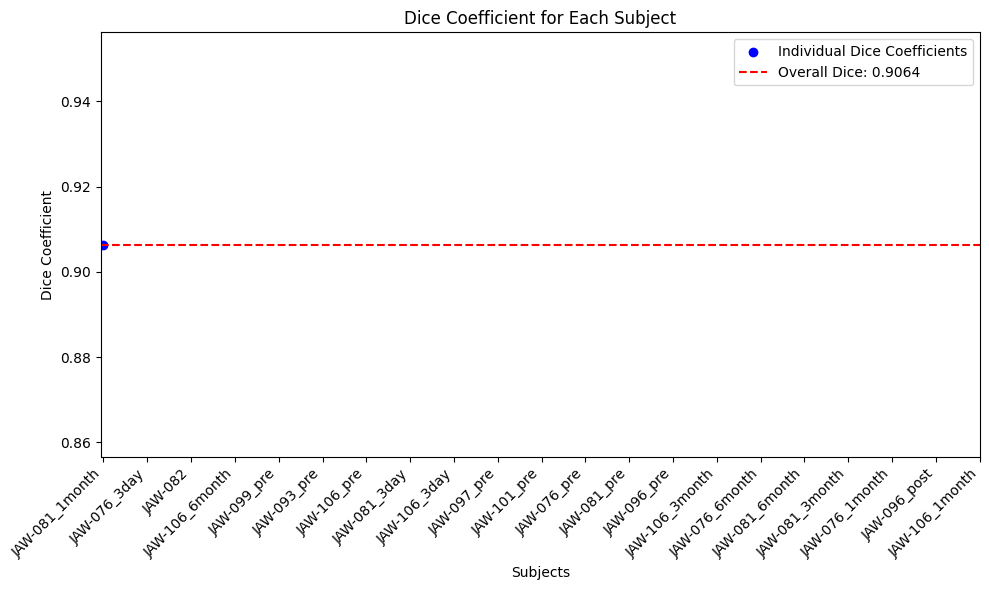

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(range(len(dice_scores)), dice_scores, color='blue', label='Individual Dice Coefficients')
plt.axhline(overall_dice, color='red', linestyle='--', label=f'Overall Dice: {overall_dice:.4f}')
plt.xlabel('Subjects')
plt.ylabel('Dice Coefficient')
plt.title('Dice Coefficient for Each Subject')
plt.legend()
plt.xticks(range(len(subfolders)), subfolders, rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [15]:
!pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 73.2 MB/s eta 0:00:00:00:0100:01


[DEBUG] NiftiArrayIO.load(): no header extensions found!


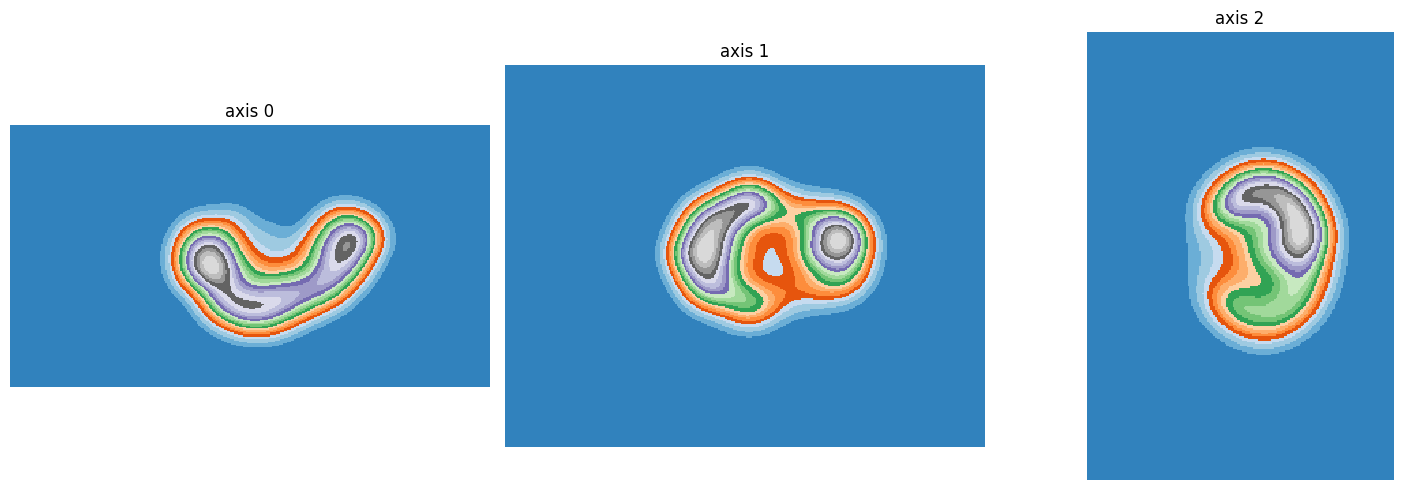

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [28]:
import os
import numpy as np
import surfa as sf
import neurite as ne
from scipy import ndimage
from sklearn.metrics import jaccard_score
from utils import find_bounding_box, find_random_bounding_box, apply_gaussian_smoothing, extract_cube
import SimpleITK as sitk  # Import SimpleITK for image registration
from scipy.ndimage import gaussian_filter

def make_smooth(label_map):
    smoothed_labels = gaussian_filter(label_map.astype(float), sigma=10)
    return np.round(smoothed_labels).astype(int)
    

a=sf.load_volume("/cbica/home/dadashkj/upenn_pigAnatomical/template/french_atlas.nii.gz")
a = make_smooth(a)
ne.plot.volume3D(a,cmaps=['tab20c'])

In [29]:
print(len(np.unique(a.astype(np.int32))))

116


In [26]:
len(np.unique(a))

71834